In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sun Mar  3 20:33:17 2019

@author: alexandreduval
"""



########################## INTERPRETATION METHODS 

#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing 
import os
import io
import itertools
import warnings
import math  # for missing values 
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import seaborn as sns #visualization
warnings.filterwarnings("ignore")
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # encode categorical variables 
from sklearn.preprocessing import StandardScaler  # standardize data
from sklearn.model_selection import train_test_split  # split between train and test split
from xgboost import XGBClassifier  # model 
import xgboost as xgb
from yellowbrick.classifier import DiscriminationThreshold  # find best threshold for classification
from imblearn.over_sampling import SMOTE   # unbalanced dataset
from imblearn.over_sampling import SMOTENC  # unbalanced dataset, deals with categorical variables
from sklearn.model_selection import cross_val_score  # assess performance, avoid overfitting 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, roc_auc_score,roc_curve,scorer,f1_score, precision_score,recall_score  # performance metrics
import statsmodels.api as sm
from sklearn.feature_selection import RFECV, RFE  # feature selection 
from xgboost import plot_tree  # plot Tree XGBoost



# Import dataset 
telcom = pd.read_csv('Telco_customer_churn.csv')
dataset = pd.read_csv('Telco_customer_churn.csv')




############# DATA MANIPULATION 


## Identify missing values 
w=float('nan')
math.isnan(w)
telcom.isna().sum()

# Missing values 
telcom[telcom['TotalCharges']== " "] # 11 missing values for the Total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan) # replace spaces with null values in TotalCharges column
telcom = telcom[telcom["TotalCharges"].notnull()] # drop these observations 
telcom = telcom.reset_index()[telcom.columns] # reset index 
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float) #convert to float type

#Replace 'No internet service' to 'No' for the following columns. If they don't have internet, they don't have access to these services. 
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies']           
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
# Replace 'No phone service' to 'No' for the MultipleLines columns. 
telcom['MultipleLines'] = telcom['MultipleLines'].replace({'No phone service':'No'})
    
# Modify Senior Citizen binary dummy variable. Want Yes or No instead of 0,1; only because other dummies are in this format. Easier to deal with. 
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})
                                      
#Separating churn and non churn customers. 
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

# Customer id col
Id_col     = ['customerID']
# Target columns
target_col = ["Churn"]
# Categorical columns
categorical_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24,25]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]




################ Feature engineering part


# Label encoding for Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
  
    
# Encode categorical variables. 
telcom = pd.get_dummies(data = telcom,columns = multi_cols )
# No need to delete some dummies to avoid the dummy variable trap, Python handles it. 


# Define dependent and independent variables 
X = telcom.iloc[:, 1: 32]  # delete customer ID from X because won't use it to predict churn. 
X = X.drop(['Churn'], axis = 1) # create dataframe with only independent variables. 
X = X.astype(float)   # keep a dataframe but where all columns are floats. 
Z = X.values  # Save X as an array under the name Z
y = telcom['Churn'].values   # dependent variables, as array. 
features = [i for i in telcom.columns if i not in Id_col + target_col] # Store the name of all variables. 


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size = 0.2, random_state=44)


<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.99
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
         24.85 <0.005     20.62
1.0


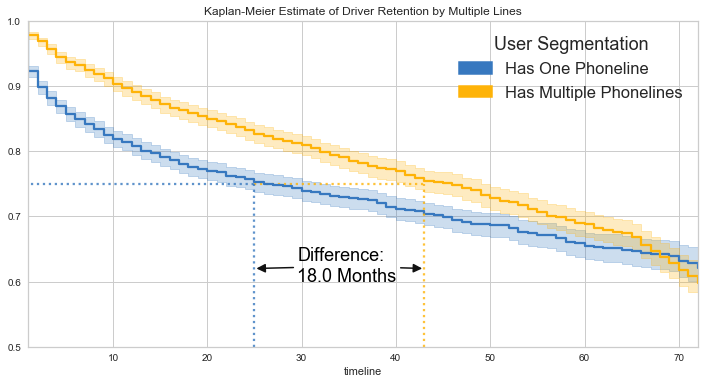

In [2]:

import lifelines
from lifelines import KaplanMeierFitter #survival analysis library
from lifelines.statistics import logrank_test #survival statistical testing
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.patches as mpatches #for custom legends
%matplotlib inline



kmf = KaplanMeierFitter()
T = telcom['tenure'] #duration
C = telcom['Churn'] #censorship - 1 if death/churn is seen, 0 if censored

palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0

##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
for segment in telcom.MultipleLines.unique(): 
    ix = telcom.MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))

    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    
    vlines.append([y_, ymax_])
    i+=1

##PLOT ANNOTATION
#for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

## position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

#label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )

#label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )

##LEGEND
#override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');



# To get hazard ratio, we run the logrank test.
multi = (telcom["MultipleLines"] == 1)
results = logrank_test(T[multi], T[~multi], C[multi], C[~multi], alpha=0.99 ) #at 99% confidence level
results.print_summary()

Z = results.test_statistic
D = C.sum() #number of events observed

hazard_ratio = np.exp(Z*np.sqrt(4/D))
print(hazard_ratio)



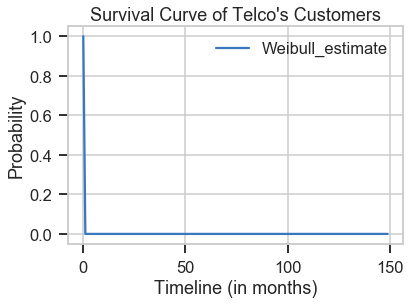

In [3]:


def plot_surv_weibull(weibull_model, ax, max_time = 150):
    max_time = np.floor(max_time).astype(int)
    x = np.array(range(max_time))
    y = np.exp(-(weibull_model.lambda_*x)**weibull_model.rho_)
    ax.plot(x,y, label = weibull_model._label)
    plt.legend()
    
weib = lifelines.WeibullFitter()
weib.fit(durations = telcom.tenure, event_observed = telcom.Churn)
ax = plt.subplot(111)
plot_surv_weibull(weib, ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability")
plt.show()

In [4]:

# remove the customer who just started
telcom2 = telcom[telcom.tenure != 0]


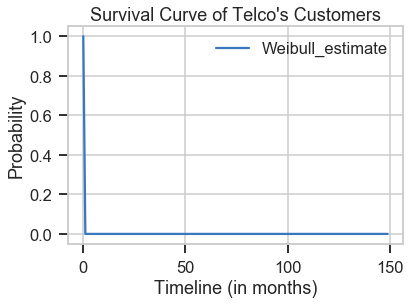

In [5]:
def plot_surv_weibull(weibull_model, ax, max_time = 150):
    max_time = np.floor(max_time).astype(int)
    x = np.array(range(max_time))
    y = np.exp(-(weibull_model.lambda_*x)**weibull_model.rho_)
    ax.plot(x,y, label = weibull_model._label)
    plt.legend()
    
weib = lifelines.WeibullFitter()
weib.fit(durations = telcom2.tenure, event_observed = telcom2.Churn)
ax = plt.subplot(111)
plot_surv_weibull(weib, ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability")
plt.show()

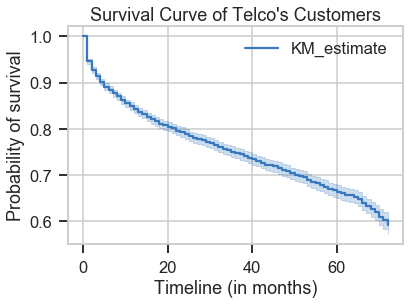

In [8]:
kmf.fit(T, event_observed=C)

kmf.survival_function_
kmf.confidence_interval_
kmf.median_
kmf.plot()
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
plt.show()

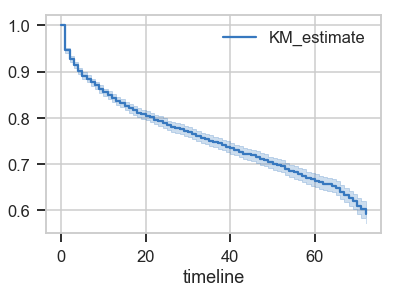

In [9]:
kmf.fit(T, event_observed=C)

kmf.survival_function_
kmf.plot()

In [10]:
exf = ExponentialFitter().fit(T, C, label='ExponentalFitter')

NameError: name 'ExponentialFitter' is not defined

In [ ]:
# Import lifelines library - survival analysis 
import lifelines

# Modify dataset telcom
del telcom['customerID']

# Kaplan Meier estimator 
from lifelines import KaplanMeierFitter
T = telcom['tenure'] #duration
C = telcom['Churn'] #censorship - 1 if death/churn is seen, 0 if censored
kmf.fit(T, event_observed=C, label='KM_estimate')

# Plot Kaplan Meier estimate of survival curve
kmf.survival_function_
kmf.plot()
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
plt.show()

# Some related statistics 
kmf.confidence_interval_
kmf.median_

# Options of the plot
kmf.plot(show_censors=False, ci_show=True, at_risk_counts=True)
plt.title("Survival Curve of Telco's Customers")
plt.show()

In [11]:
print(1)

1


Text(0,0.5,'Probability of survival')

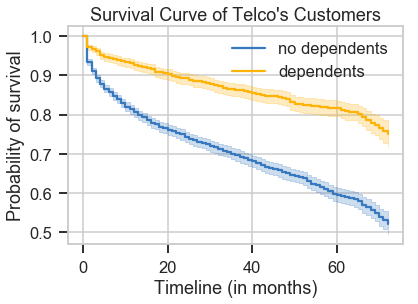

In [12]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Dependents == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no dependents')
ax = kmf.plot()
kmf.fit(T[has_dependents], C[has_dependents], label='dependents')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

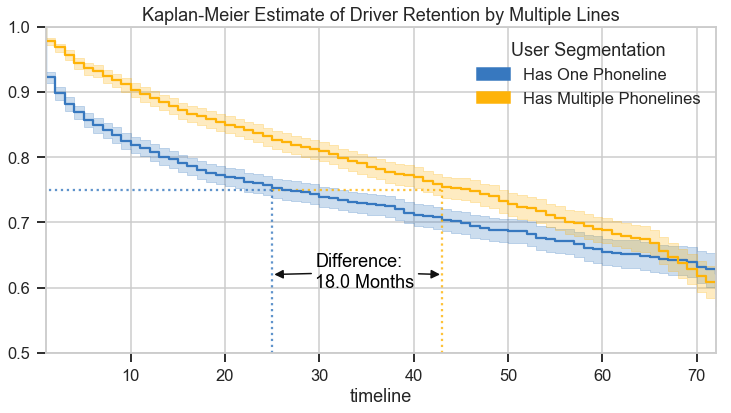

In [13]:
# Kaplan Meier estimate of the survival curve, semented by the attribute MultipleLines. 

palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0

##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
for segment in telcom.MultipleLines.unique(): 
    ix = telcom.MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))
    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    vlines.append([y_, ymax_])
    i+=1

# PLOT ANNOTATION
# for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

# position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

# label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )
  
# label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )
      
# #LEGEND
# override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');




Text(0,0.5,'Probability of survival')

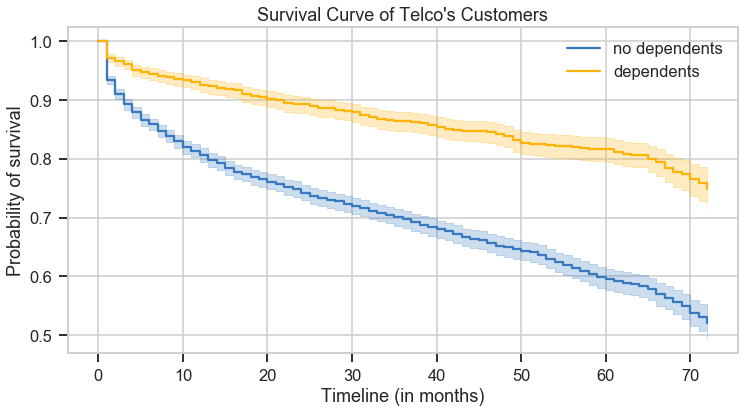

In [14]:
has_dependents = (telcom.Dependents == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no dependents')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='dependents')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

Text(0,0.5,'Probability of survival')

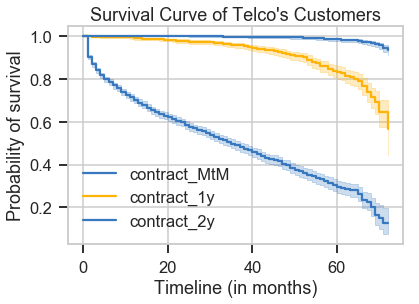

In [15]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['Contract_Month-to-month'] == 1)
contract_1y = (telcom['Contract_One year'] == 1)
contract_2y = (telcom['Contract_Two year'] == 1)
kmf.fit(T[contract_MtM], C[contract_MtM], label='contract_MtM')
ax = kmf.plot()
kmf.fit(T[contract_1y], C[contract_1y], label='contract_1y')
ax = kmf.plot(ax=ax)
kmf.fit(T[contract_2y], C[contract_2y], label='contract_2y')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

Text(0,0.5,'Probability of survival')

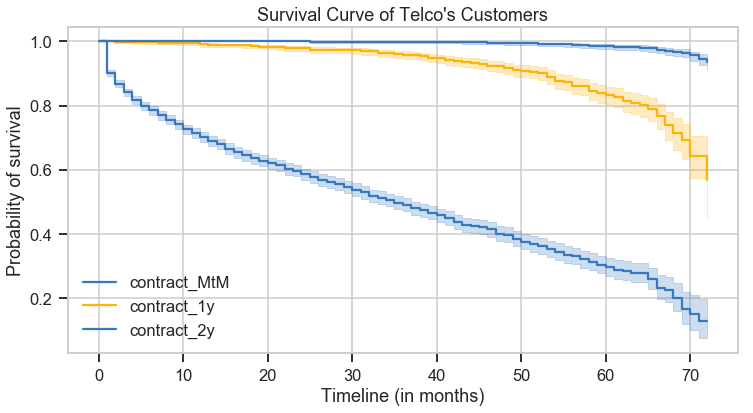

In [16]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['Contract_Month-to-month'] == 1)
contract_1y = (telcom['Contract_One year'] == 1)
contract_2y = (telcom['Contract_Two year'] == 1)
kmf.fit(T[contract_MtM], C[contract_MtM], label='contract_MtM')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[contract_1y], C[contract_1y], label='contract_1y')
ax = kmf.plot(ax=ax, figsize=(12,6))
kmf.fit(T[contract_2y], C[contract_2y], label='contract_2y')
ax = kmf.plot(ax=ax, figsize=(12,6))
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

Text(0,0.5,'Probability of survival')

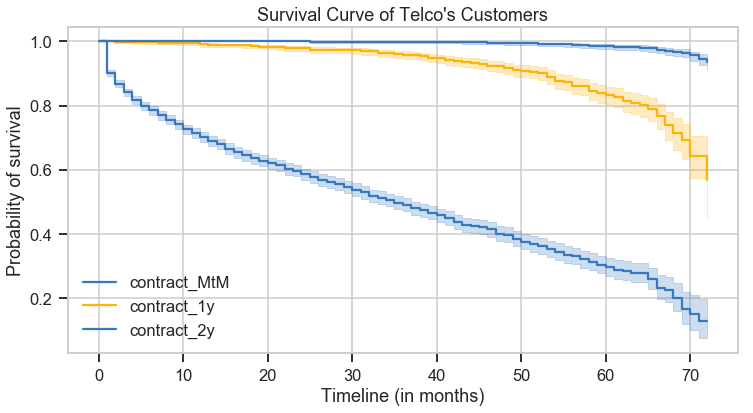

In [17]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['Contract_Month-to-month'] == 1)
contract_1y = (telcom['Contract_One year'] == 1)
contract_2y = (telcom['Contract_Two year'] == 1)
kmf.fit(T[contract_MtM], C[contract_MtM], label='contract_MtM')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[contract_1y], C[contract_1y], label='contract_1y')
ax = kmf.plot(ax=ax, figsize=(12,6))
kmf.fit(T[contract_2y], C[contract_2y], label='contract_2y')
ax = kmf.plot(ax=ax, figsize=(12,6))
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

In [19]:
telcom_cox = telcom.drop(['Contract_Month-to-month', 'PaymentMethod_Credit card (automatic)', 'InternetService_No'], axis=1)


In [22]:
cph = CoxPHFitter()

In [24]:
del telcom['customerID']

In [25]:
from lifelines import KaplanMeierFitter
T = telcom['tenure'] #duration
C = telcom['Churn'] #censorship - 1 if death/churn is seen, 0 if censored
kmf.fit(T, event_observed=C, label='KM_estimate')

<lifelines.KaplanMeierFitter: fitted with 7032 observations, 5163 censored>

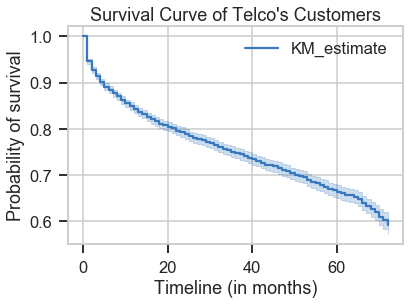

In [26]:
kmf.survival_function_
kmf.plot()
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
plt.show()

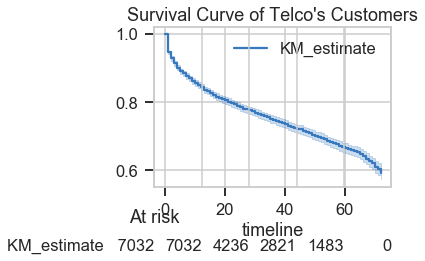

In [27]:
kmf.plot(show_censors=False, ci_show=True, at_risk_counts=True)
plt.title("Survival Curve of Telco's Customers")
plt.show()

AttributeError: 'module' object has no attribute 'figsize'

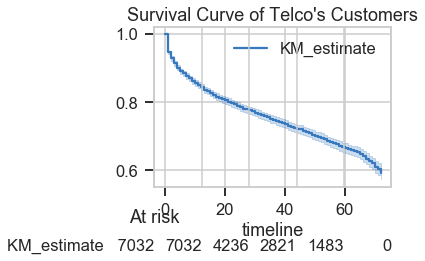

In [28]:
kmf.plot(show_censors=False, ci_show=True, at_risk_counts=True)
plt.title("Survival Curve of Telco's Customers")
plt.figsize(6,9)
plt.show()

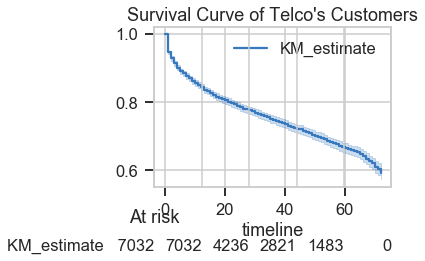

<Figure size 432x648 with 0 Axes>

In [29]:
kmf.plot(show_censors=False, ci_show=True, at_risk_counts=True)
plt.title("Survival Curve of Telco's Customers")
plt.figure(figsize =(6,9))
plt.show()

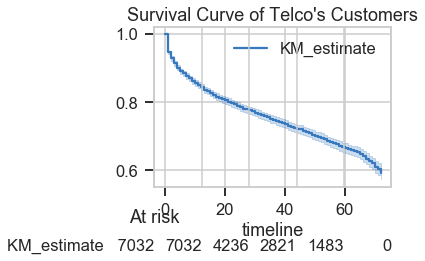

<Figure size 648x864 with 0 Axes>

In [30]:
kmf.plot(show_censors=False, ci_show=True, at_risk_counts=True)
plt.title("Survival Curve of Telco's Customers")
plt.figure(figsize =(9,12))
plt.show()

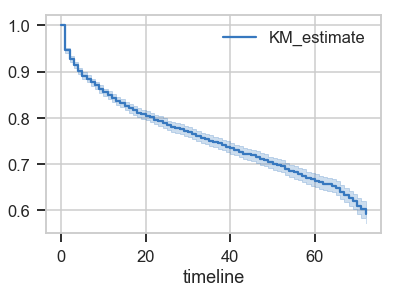

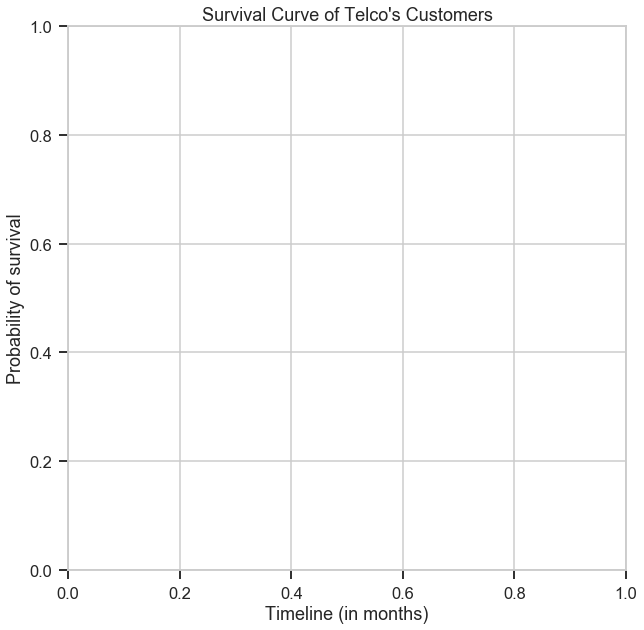

In [31]:
kmf.survival_function_
kmf.plot()
plt.figure(figsize=(10,10))
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
plt.show()

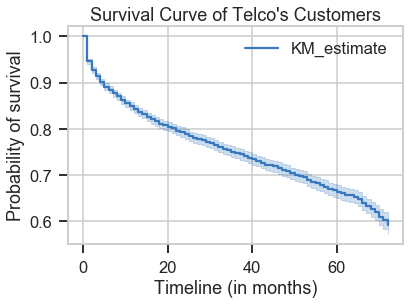

In [32]:
# Plot Kaplan Meier estimate of survival curve
kmf.survival_function_
kmf.plot()
plt.figure(num =1, figsize=(10,10))
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
plt.show()

In [33]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
cph.plot(figsize=(9,6))
cph.print_summary()


TypeError: DataFrame contains nonnumeric columns: ['customerID']. Try 1) using pandas.get_dummies to convert the non-numeric column(s) to numerical data, 2) using it in stratification `strata=`, or 3) dropping the column(s).

In [34]:
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.plot(cph.plot())
cph.print_summary()

TypeError: DataFrame contains nonnumeric columns: ['customerID']. Try 1) using pandas.get_dummies to convert the non-numeric column(s) to numerical data, 2) using it in stratification `strata=`, or 3) dropping the column(s).

In [35]:
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(1)
plt.subplot(211)
plt.plot()

TypeError: DataFrame contains nonnumeric columns: ['customerID']. Try 1) using pandas.get_dummies to convert the non-numeric column(s) to numerical data, 2) using it in stratification `strata=`, or 3) dropping the column(s).

In [36]:
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(1)
plt.subplot(211)

TypeError: DataFrame contains nonnumeric columns: ['customerID']. Try 1) using pandas.get_dummies to convert the non-numeric column(s) to numerical data, 2) using it in stratification `strata=`, or 3) dropping the column(s).

In [37]:
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(1)

TypeError: DataFrame contains nonnumeric columns: ['customerID']. Try 1) using pandas.get_dummies to convert the non-numeric column(s) to numerical data, 2) using it in stratification `strata=`, or 3) dropping the column(s).

In [38]:
telcom_cox = telcom.drop(['Contract_Month-to-month', 'PaymentMethod_Credit card (automatic)', 'InternetService_No'], axis=1)


In [39]:
# Modify dataset telcom
del telcom['customerID']

KeyError: 'customerID'

In [40]:
telcom


gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
5          0              0        0           0       8             1   
6          1              0        0           1      22             1   
7          0              0        0           0      10             0   
8          0              0        1           0      28             1   
9          1              0        0           1      62             1   
10         1              0        1           1      13             1   
11         1              0        0           0      16             1   
12         1              0        1           0      58             1   
13         1              0        0           0      49             1   
14         1              0        0           0      25             1   
15         0              0        1           1      69             1   
16         0              0        0           0      52             1   
17         1              0        0           1      71             1   
18         0              0        1           1      10             1   
19         0              0        0           0      21             1   
20         1              1        0           0       1             0   
21         1              0        1           0      12             1   
22         1              0        0           0       1             1   
23         0              0        1           0      58             1   
24         1              0        1           1      49             1   
25         0              0        0           0      30             1   
26         1              0        1           1      47             1   
27         1              0        1           1       1             0   
28         1              0        1           0      72             1   
29         0              0        0           1      17             1   
...      ...            ...      ...         ...     ...           ...   
7002       0              0        0           0      40             1   
7003       1              0        0           0      41             1   
7004       1              1        1           0      34             1   
7005       0              0        0           0       1             1   
7006       0              0        0           0      51             1   
7007       1              0        1           1       1             1   
7008       0              0        0           0      39             1   
7009       1              0        1           1      12             1   
7010       1              0        0           0      12             1   
7011       1              0        0           0      72             1   
7012       0              1        1           0      63             1   
7013       1              0        1           0      44             1   
7014       0              0        0           0      18             1   
7015       0              0        0           0       9             1   
7016       1              0        0           0      13             1   
7017       0              0        1           0      68             1   
7018       0              1        0           0       6             0   
7019       0              0        0           0       2             1   
7020       1              1        1           0      55             1   
7021       1              1        0           0       1             1   
7022       1              0        0           0      38             1   
7023       0              0        0           0      67             1   
7024      

In [41]:
telcom_cox


gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
5          0              0        0           0       8             1   
6          1              0        0           1      22             1   
7          0              0        0           0      10             0   
8          0              0        1           0      28             1   
9          1              0        0           1      62             1   
10         1              0        1           1      13             1   
11         1              0        0           0      16             1   
12         1              0        1           0      58             1   
13         1              0        0           0      49             1   
14         1              0        0           0      25             1   
15         0              0        1           1      69             1   
16         0              0        0           0      52             1   
17         1              0        0           1      71             1   
18         0              0        1           1      10             1   
19         0              0        0           0      21             1   
20         1              1        0           0       1             0   
21         1              0        1           0      12             1   
22         1              0        0           0       1             1   
23         0              0        1           0      58             1   
24         1              0        1           1      49             1   
25         0              0        0           0      30             1   
26         1              0        1           1      47             1   
27         1              0        1           1       1             0   
28         1              0        1           0      72             1   
29         0              0        0           1      17             1   
...      ...            ...      ...         ...     ...           ...   
7002       0              0        0           0      40             1   
7003       1              0        0           0      41             1   
7004       1              1        1           0      34             1   
7005       0              0        0           0       1             1   
7006       0              0        0           0      51             1   
7007       1              0        1           1       1             1   
7008       0              0        0           0      39             1   
7009       1              0        1           1      12             1   
7010       1              0        0           0      12             1   
7011       1              0        0           0      72             1   
7012       0              1        1           0      63             1   
7013       1              0        1           0      44             1   
7014       0              0        0           0      18             1   
7015       0              0        0           0       9             1   
7016       1              0        0           0      13             1   
7017       0              0        1           0      68             1   
7018       0              1        0           0       6             0   
7019       0              0        0           0       2             1   
7020       1              1        1           0      55             1   
7021       1              1        0           0       1             1   
7022       1              0        0           0      38             1   
7023       0              0        0           0      67             1   
7024      

Iteration 1: norm_delta = 2.34743, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.82231, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.94170, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.40984, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence completed after 7 iterations.


<Figure size 648x432 with 0 Axes>

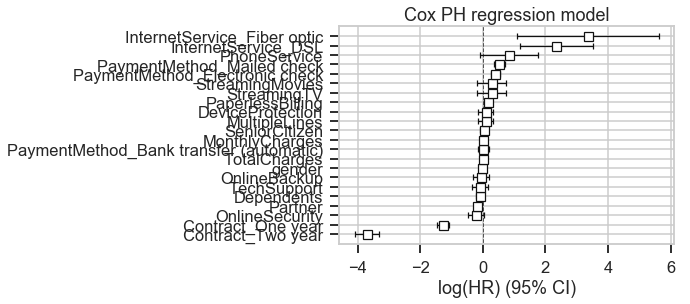

In [42]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(9,6))
p = cph.plot()
plt.title('Cox PH regression model')
plt.show()

Iteration 1: norm_delta = 2.34743, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.82231, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.94170, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.40984, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence completed after 7 iterations.


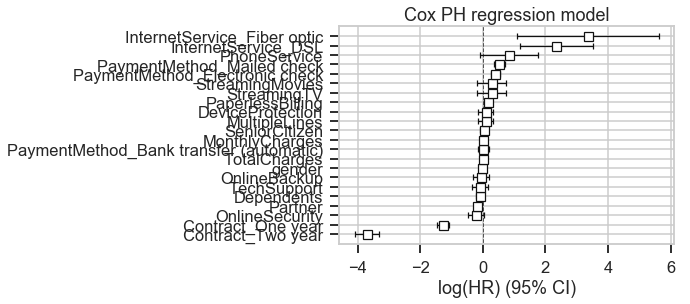

In [43]:
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
p = cph.plot()
plt.title('Cox PH regression model')
plt.show()

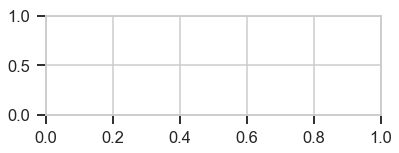

In [44]:
plt.figure(1)
plt.subplot(211)

In [45]:
plt.figure(1, figsize=(9,6))


<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

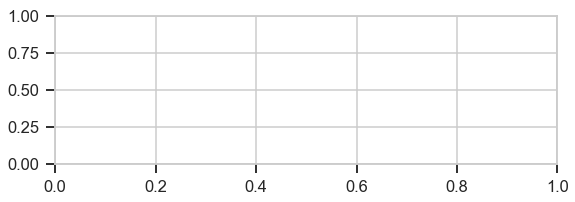

In [46]:
plt.figure(1, figsize=(9,6))
plt.subplot(211)

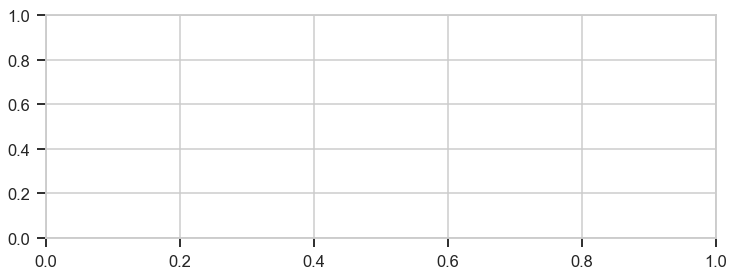

In [47]:
plt.figure(1, figsize=(12,9))
plt.subplot(211)

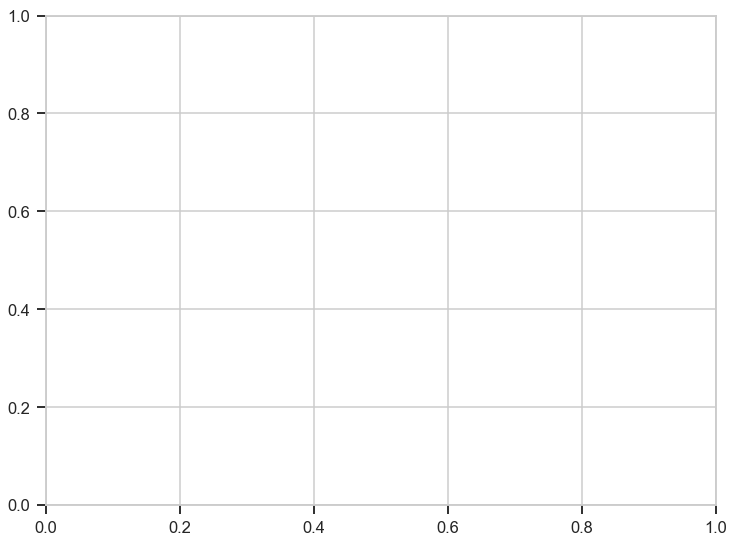

In [48]:
plt.figure(1, figsize=(12,9))
plt.subplot()


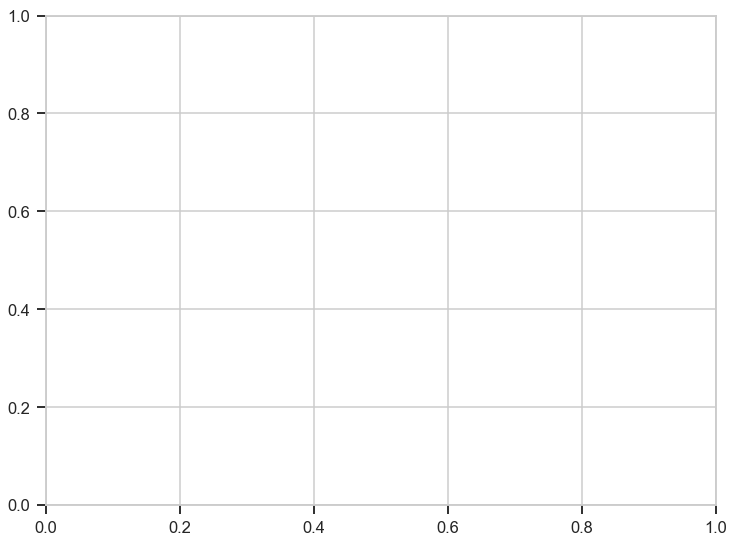

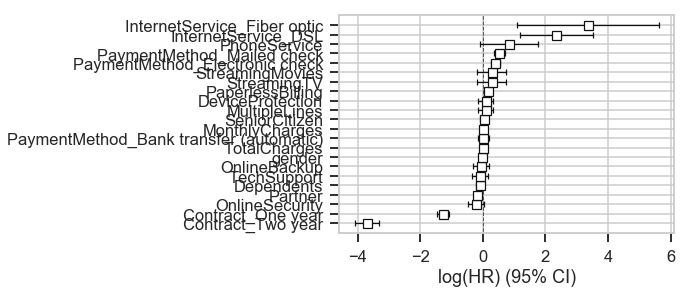

In [49]:
plt.figure(1, figsize=(12,9))
plt.subplot()
cph.plot()

<Figure size 864x648 with 0 Axes>

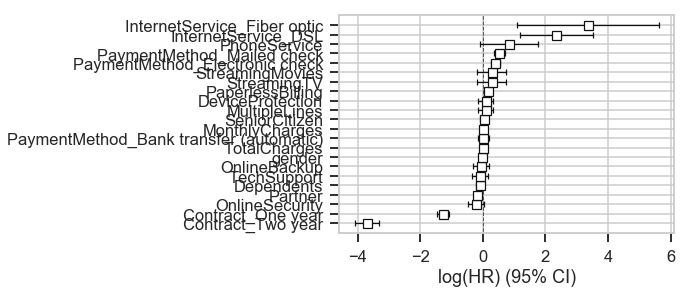

In [50]:
plt.figure(1, figsize=(12,9))
plt.subplot(cph.plot())

In [51]:
plt.figure(1, figsize=(12,9))

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

ValueError: Illegal argument(s) to subplot: (1, <matplotlib.axes._subplots.AxesSubplot object at 0x1c23303050>)

<Figure size 864x648 with 0 Axes>

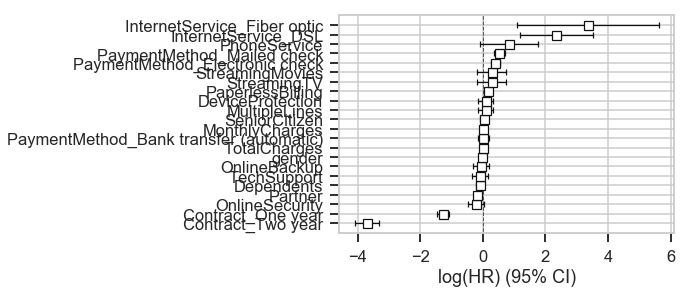

In [52]:
plt.figure(1, figsize=(12,9))
plt.subplot(1, cph.plot())
plt.show()
cph.plot(1)

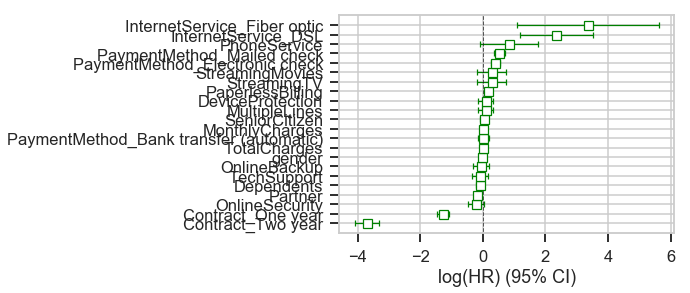

In [53]:
cph.plot(color='green')

RuntimeError: Can not put single artist in more than one figure

<Figure size 864x648 with 0 Axes>

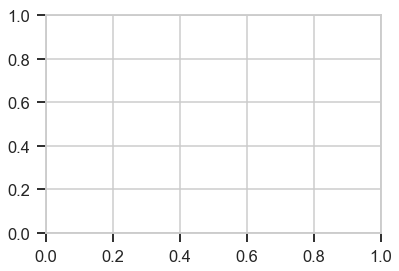

In [54]:
a = plt.figure(figsize=(12,9))
cph.plot(figure= a)

RuntimeError: Can not put single artist in more than one figure

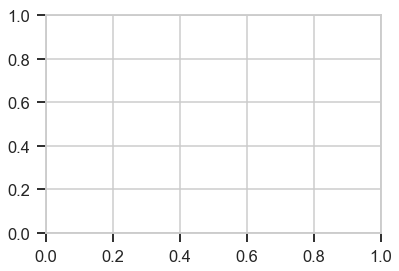

In [55]:
cph.plot(figure= (12,9))

RuntimeError: Can not put single artist in more than one figure

<Figure size 864x648 with 0 Axes>

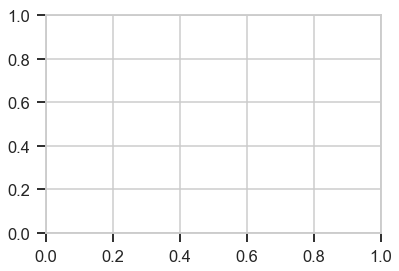

In [56]:
cph.plot(figure= plt.figure(figsize=(12,9)))

RuntimeError: Can not put single artist in more than one figure

<Figure size 864x648 with 0 Axes>

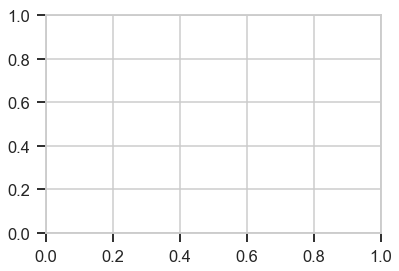

In [57]:
plt.figure(num = 1, figsize=(12,9))
cph.plot(figure = 1)

AttributeError: Unknown property in_layout

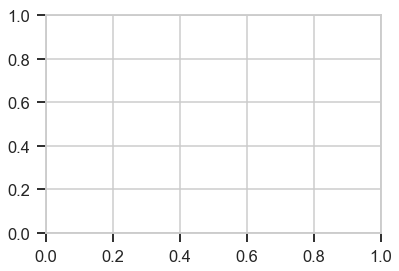

In [58]:
cph.plot(in_layout=False)

AttributeError: Unknown property in_layout

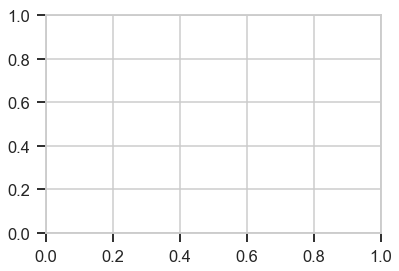

In [59]:
cph.plot(in_layout=False)

TypeError: 'CoxPHFitter' object is not callable

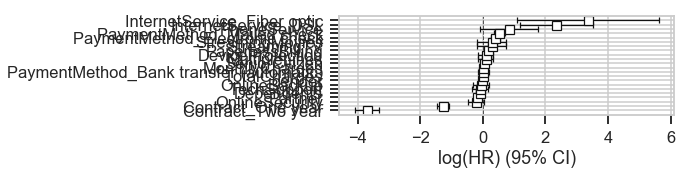

In [61]:
ax = plt.subplot(2,1,1)
cph.plot(ax=ax)

In [62]:
plt.figure(fisize=(9,9))
ax = plt.subplot()
cph.plot(ax=ax)

TypeError: __init__() got an unexpected keyword argument 'fisize'

In [63]:
plt.figure(1, fisize=(9,9))
ax = plt.subplot(1)
cph.plot(ax=ax)

TypeError: __init__() got an unexpected keyword argument 'fisize'

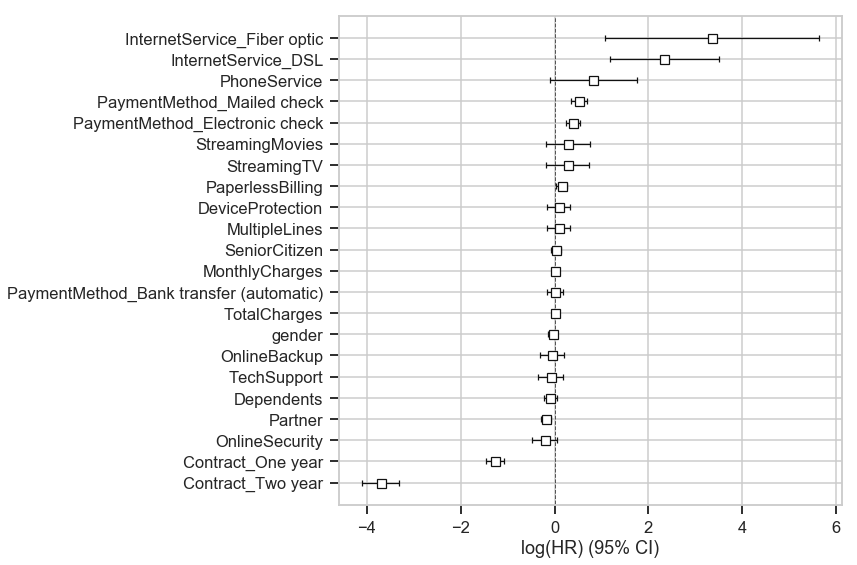

In [64]:
plt.figure(figsize=(9,9))
ax = plt.subplot()
cph.plot(ax=ax)

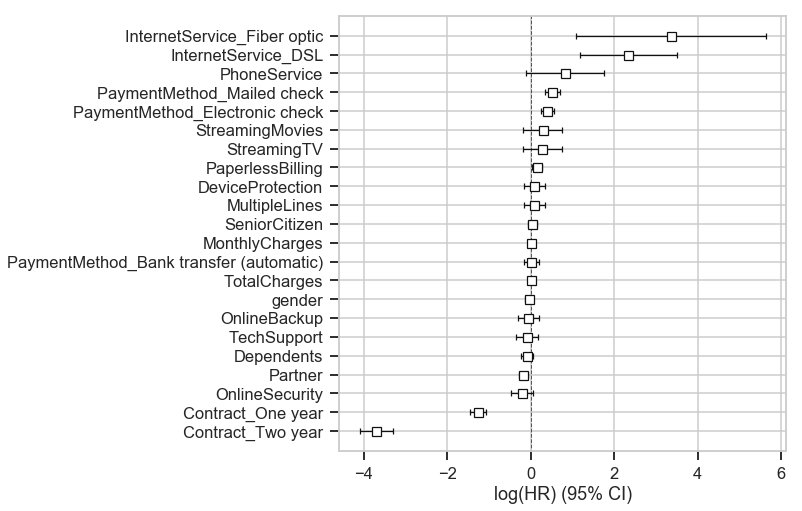

In [65]:
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)

Iteration 1: norm_delta = 2.34743, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.82231, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.94170, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.40984, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.3
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.3
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.4
Convergence completed after 7 iterations.


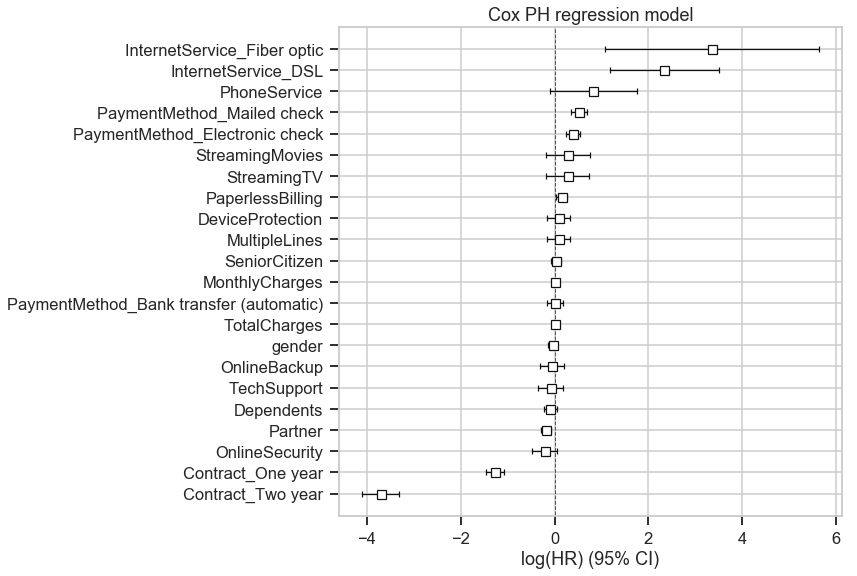

In [66]:
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(9,9))
ax = plt.subplot()
cph.plot(ax=ax)
plt.title('Cox PH regression model')
plt.show()

Iteration 1: norm_delta = 2.34743, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.82231, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.94170, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.40984, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.3
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.3
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.4
Convergence completed after 7 iterations.


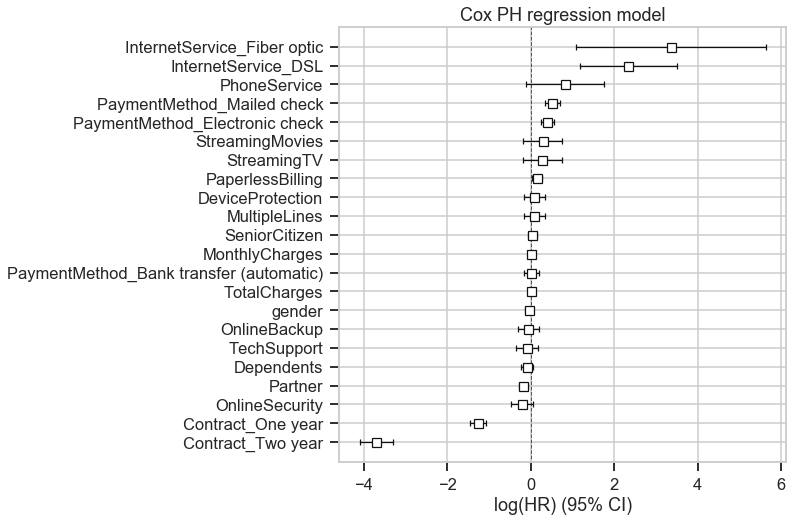

In [67]:
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
plt.title('Cox PH regression model')
plt.show()

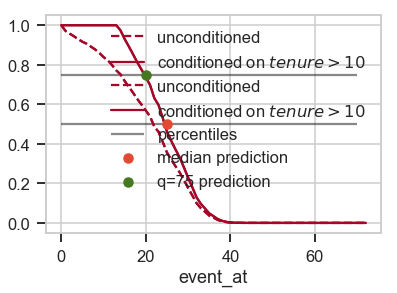

In [68]:
# Predict event time of censored individuals (only those who did not churn during the study time)
censored_subjects = telcom_cox.loc[telcom_cox['Churn'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[telcom_cox.loc[c.name, 'tenure']]).clip_upper(1))
# let's focus on a single subject
subject = 30
unconditioned_sf.iloc[:,subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf.iloc[:,subject].plot(color="#A60628", label="conditioned on $tenure>10$")
plt.legend(loc='upper_right')


# From here, you can pick a median or percentile as a best guess as to the subject’s event time:
from lifelines.utils import median_survival_times, qth_survival_times
predictions_50 = median_survival_times(conditioned_sf)
predictions_75 = qth_survival_times(0.75, conditioned_sf)

# plotting subject 30 again
subject = 30
unconditioned_sf.iloc[:,subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf.iloc[:,subject].plot(color="#A60628", label="conditioned on $tenure>10$")
plt.hlines([0.5, 0.75], 0, 70, alpha=0.5, label="percentiles")
plt.scatter(median_survival_times(conditioned_sf.iloc[:,subject]), 0.5,  color="#E24A33", label="median prediction", zorder=20)
plt.scatter(qth_survival_times(0.75, conditioned_sf.iloc[:,subject]), 0.75,  color="#467821", label="q=75 prediction", zorder=20)
plt.legend()

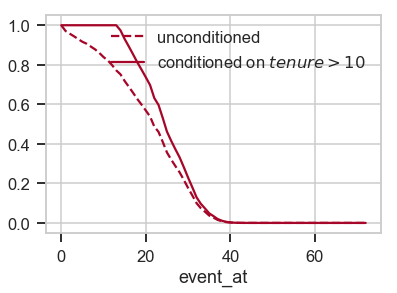

In [69]:
# Predict event time of censored individuals (only those who did not churn during the study time)
censored_subjects = telcom_cox.loc[telcom_cox['Churn'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[telcom_cox.loc[c.name, 'tenure']]).clip_upper(1))
# let's focus on a single subject
subject = 30
unconditioned_sf.iloc[:,subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf.iloc[:,subject].plot(color="#A60628", label="conditioned on $tenure>10$")
plt.legend(loc='upper_right')




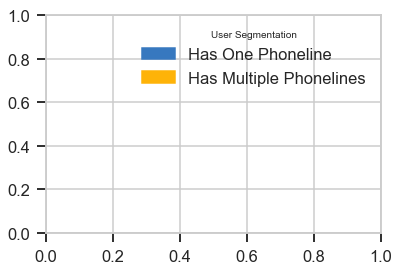

In [70]:

# Improved version mentionned above
# Kaplan Meier estimate of the survival curve, semented by the attribute MultipleLines. 
palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0

##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
for segment in telcom.MultipleLines.unique(): 
    ix = telcom.MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))
    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    vlines.append([y_, ymax_])
    i+=1

# PLOT ANNOTATION
# for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

# position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

# label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           ) 
  
# label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )    
      
##LEGEND
# override default legend - little legend square on the graph
import matplotlib.patches as mpatches #for custom legends
%matplotlib inline
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');


NameError: name 'df' is not defined

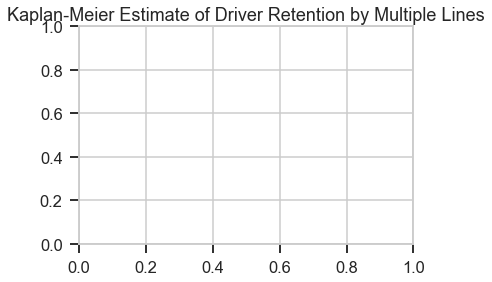

In [71]:
palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0

##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
for segment in df.b_MultipleLines.unique(): 
    ix = df.b_MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))

    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    
    vlines.append([y_, ymax_])
    i+=1

##PLOT ANNOTATION
#for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

## position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

#label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )

#label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )

##LEGEND
#override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');

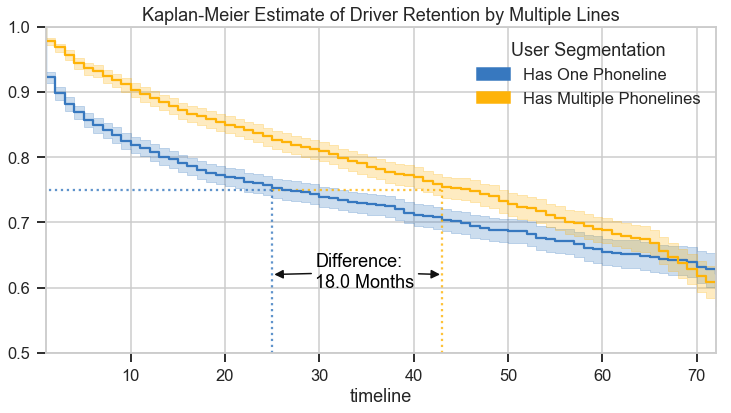

In [72]:

palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0

##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
for segment in telcom.MultipleLines.unique(): 
    ix = telcom.MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))

    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    
    vlines.append([y_, ymax_])
    i+=1

##PLOT ANNOTATION
#for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

## position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

#label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )

#label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )

##LEGEND
#override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');



In [73]:
print(1)

1


In [74]:
telcom

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
5          0              0        0           0       8             1   
6          1              0        0           1      22             1   
7          0              0        0           0      10             0   
8          0              0        1           0      28             1   
9          1              0        0           1      62             1   
10         1              0        1           1      13             1   
11         1              0        0           0      16             1   
12         1              0        1           0      58             1   
13         1              0        0           0      49             1   
14         1              0        0           0      25             1   
15         0              0        1           1      69             1   
16         0              0        0           0      52             1   
17         1              0        0           1      71             1   
18         0              0        1           1      10             1   
19         0              0        0           0      21             1   
20         1              1        0           0       1             0   
21         1              0        1           0      12             1   
22         1              0        0           0       1             1   
23         0              0        1           0      58             1   
24         1              0        1           1      49             1   
25         0              0        0           0      30             1   
26         1              0        1           1      47             1   
27         1              0        1           1       1             0   
28         1              0        1           0      72             1   
29         0              0        0           1      17             1   
...      ...            ...      ...         ...     ...           ...   
7002       0              0        0           0      40             1   
7003       1              0        0           0      41             1   
7004       1              1        1           0      34             1   
7005       0              0        0           0       1             1   
7006       0              0        0           0      51             1   
7007       1              0        1           1       1             1   
7008       0              0        0           0      39             1   
7009       1              0        1           1      12             1   
7010       1              0        0           0      12             1   
7011       1              0        0           0      72             1   
7012       0              1        1           0      63             1   
7013       1              0        1           0      44             1   
7014       0              0        0           0      18             1   
7015       0              0        0           0       9             1   
7016       1              0        0           0      13             1   
7017       0              0        1           0      68             1   
7018       0              1        0           0       6             0   
7019       0              0        0           0       2             1   
7020       1              1        1           0      55             1   
7021       1              1        0           0       1             1   
7022       1              0        0           0      38             1   
7023       0              0        0           0      67             1   
7024      

In [75]:
clear(all)

In [76]:
telcom


gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
5          0              0        0           0       8             1   
6          1              0        0           1      22             1   
7          0              0        0           0      10             0   
8          0              0        1           0      28             1   
9          1              0        0           1      62             1   
10         1              0        1           1      13             1   
11         1              0        0           0      16             1   
12         1              0        1           0      58             1   
13         1              0        0           0      49             1   
14         1              0        0           0      25             1   
15         0              0        1           1      69             1   
16         0              0        0           0      52             1   
17         1              0        0           1      71             1   
18         0              0        1           1      10             1   
19         0              0        0           0      21             1   
20         1              1        0           0       1             0   
21         1              0        1           0      12             1   
22         1              0        0           0       1             1   
23         0              0        1           0      58             1   
24         1              0        1           1      49             1   
25         0              0        0           0      30             1   
26         1              0        1           1      47             1   
27         1              0        1           1       1             0   
28         1              0        1           0      72             1   
29         0              0        0           1      17             1   
...      ...            ...      ...         ...     ...           ...   
7002       0              0        0           0      40             1   
7003       1              0        0           0      41             1   
7004       1              1        1           0      34             1   
7005       0              0        0           0       1             1   
7006       0              0        0           0      51             1   
7007       1              0        1           1       1             1   
7008       0              0        0           0      39             1   
7009       1              0        1           1      12             1   
7010       1              0        0           0      12             1   
7011       1              0        0           0      72             1   
7012       0              1        1           0      63             1   
7013       1              0        1           0      44             1   
7014       0              0        0           0      18             1   
7015       0              0        0           0       9             1   
7016       1              0        0           0      13             1   
7017       0              0        1           0      68             1   
7018       0              1        0           0       6             0   
7019       0              0        0           0       2             1   
7020       1              1        1           0      55             1   
7021       1              1        0           0       1             1   
7022       1              0        0           0      38             1   
7023       0              0        0           0      67             1   
7024      

In [77]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sun Mar  3 20:33:17 2019

@author: alexandreduval
"""



########################## INTERPRETATION METHODS 

#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing 
import os
import io
import itertools
import warnings
import math  # for missing values 
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import seaborn as sns #visualization
warnings.filterwarnings("ignore")
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # encode categorical variables 
from sklearn.preprocessing import StandardScaler  # standardize data
from sklearn.model_selection import train_test_split  # split between train and test split
from xgboost import XGBClassifier  # model 



# Import dataset 
telcom = pd.read_csv('Telco_customer_churn.csv')
dataset = pd.read_csv('Telco_customer_churn.csv')




############# DATA MANIPULATION 


## Identify missing values 
w=float('nan')
math.isnan(w)
telcom.isna().sum()

# Missing values 
telcom[telcom['TotalCharges']== " "] # 11 missing values for the Total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan) # replace spaces with null values in TotalCharges column
telcom = telcom[telcom["TotalCharges"].notnull()] # drop these observations 
telcom = telcom.reset_index()[telcom.columns] # reset index 
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float) #convert to float type

#Replace 'No internet service' to 'No' for the following columns. If they don't have internet, they don't have access to these services. 
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies']           
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
# Replace 'No phone service' to 'No' for the MultipleLines columns. 
telcom['MultipleLines'] = telcom['MultipleLines'].replace({'No phone service':'No'})
    
# Modify Senior Citizen binary dummy variable. Want Yes or No instead of 0,1; only because other dummies are in this format. Easier to deal with. 
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

dataset = telcom.iloc[:, 1:22]       
                          
#Separating churn and non churn customers. 
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

# Customer id col
Id_col     = ['customerID']
# Target columns
target_col = ["Churn"]
# Categorical columns
categorical_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24,25]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]




################ Feature engineering part


# Label encoding for Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
  
    
# Encode categorical variables. 
telcom = pd.get_dummies(data = telcom,columns = multi_cols )
# No need to delete some dummies to avoid the dummy variable trap, Python handles it. 


# Define dependent and independent variables 
X = telcom.iloc[:, 1: 32]  # delete customer ID from X because won't use it to predict churn. 
X = X.drop(['Churn'], axis = 1) # create dataframe with only independent variables. 
X = X.astype(float)   # keep a dataframe but where all columns are floats. 
Z = X.values  # Save X as an array under the name Z
y = telcom['Churn'].values   # dependent variables, as array. 
features = [i for i in telcom.columns if i not in Id_col + target_col] # Store the name of all variables. 


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size = 0.2, random_state=44)




####### MODEL IMPLEMENTATION


# Fitting tuned XGBoost to the Training set
classifier = XGBClassifier( n_estimators=150, learning_rate=0.15, max_depth=3, min_child_weight=0.6,
                            colsample_bytree=1, subsample=1, reg_alpha=0, gamma=0,
                            booster='gbtree', objective='binary:logistic') 
classifier.fit(X_train, y_train)


# Predicting the Test set and Training set results. Also store predicted probabilities used to classify. 
y_pred = classifier.predict(X_test)
y_pred2 = classifier.predict(X_train)
y_proba = classifier.predict_proba(X_test)   # illustrates confidence about predictions. Useful for interpretations. 
y_proba2 = classifier.predict_proba(X_train)  # for ICE,PDP
y_proba3 = y_proba2[:,1]  # only proba of churners 
#y_proba4 = pd.DataFrame(y_proba3)







In [78]:
print(1)

1


In [79]:
# Import lifelines library - survival analysis 
import lifelines

# Modify dataset telcom
del telcom['customerID']

In [80]:
from lifelines import KaplanMeierFitter
T = telcom['tenure'] #duration
C = telcom['Churn'] #censorship - 1 if death/churn is seen, 0 if censored
kmf.fit(T, event_observed=C, label='KM_estimate')

<lifelines.KaplanMeierFitter: fitted with 7032 observations, 5163 censored>

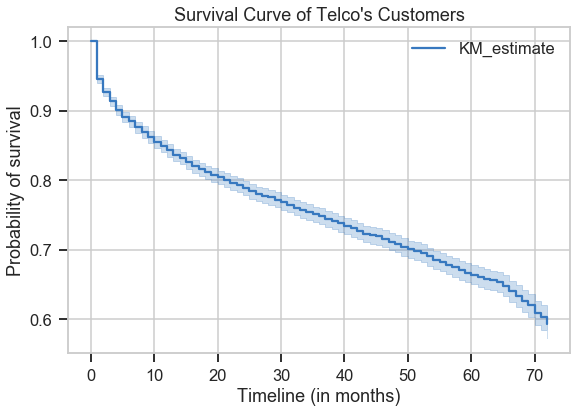

In [81]:
# Plot Kaplan Meier estimate of survival curve
kmf.survival_function_
kmf.plot(figsize=(9,6))
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
plt.show()


      KM_estimate_upper_0.95  KM_estimate_lower_0.95
0.0                      NaN                     NaN
1.0                 0.951002                0.940418
2.0                 0.933672                0.921506
3.0                 0.920108                0.906857
4.0                 0.907879                0.893733
5.0                 0.898276                0.883473
6.0                 0.892194                0.876991
7.0                 0.884332                0.868630
8.0                 0.877756                0.861650
9.0                 0.870439                0.853893
10.0                0.863174                0.846204
11.0                0.858096                0.840836
12.0                0.851783                0.834169
13.0                0.845365                0.827396
14.0                0.841250                0.823056
15.0                0.834832                0.816292
16.0                0.829907                0.811107
17.0                0.825280                0.

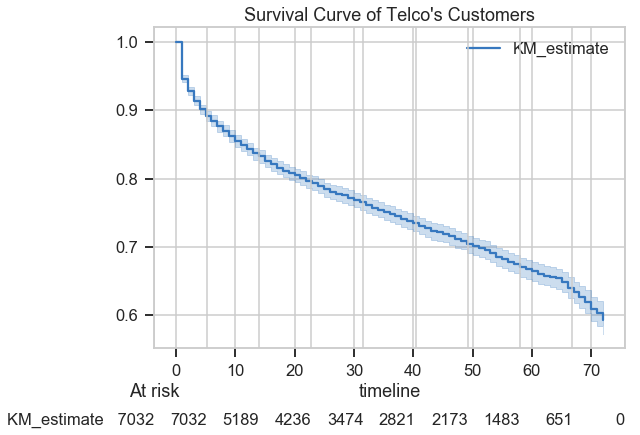

In [82]:
# Some related statistics 
print(kmf.confidence_interval_)
# Accurate table values used to plot survival function
print(kmf.survival_function_)
print('median', kmf.median_)

# Options of the plot
kmf.plot(show_censors=False, ci_show=True, at_risk_counts=True,figsize=(9,6) )
plt.title("Survival Curve of Telco's Customers")
plt.show()

In [83]:
# Survival Tables
from lifelines.utils import survival_table_from_events
table = survival_table_from_events(T, C)
print(table.head(10))

          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0      7032     7032
1.0           613       380       233         0     7032
2.0           238       123       115         0     6419
3.0           200        94       106         0     6181
4.0           176        83        93         0     5981
5.0           133        64        69         0     5805
6.0           110        40        70         0     5672
7.0           131        51        80         0     5562
8.0           123        42        81         0     5431
9.0           119        46        73         0     5308


Text(0,0.5,'Probability of survival')

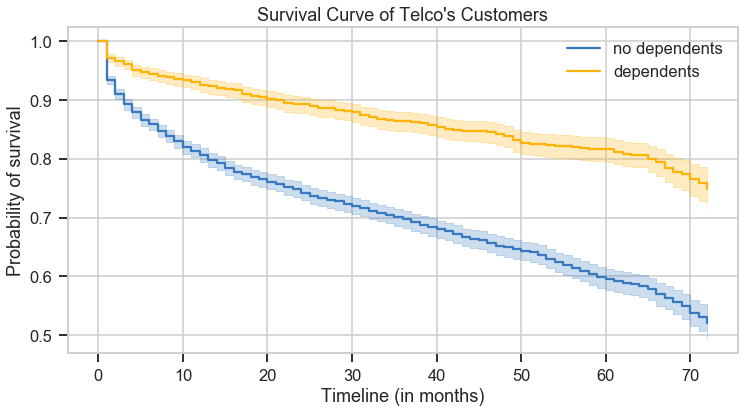

In [84]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Dependents == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no dependents')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='dependents')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

In [85]:
print(kmf.confidence_interval_)

      dependents_upper_0.95  dependents_lower_0.95
0.0                     NaN                    NaN
1.0                0.978570               0.964403
2.0                0.974282               0.958952
3.0                0.969033               0.952406
4.0                0.960087               0.941490
5.0                0.956898               0.937655
6.0                0.954129               0.934341
7.0                0.951319               0.930990
8.0                0.948466               0.927600
9.0                0.945562               0.924156
10.0               0.943602               0.921839
11.0               0.941121               0.918910
12.0               0.937094               0.914172
13.0               0.934535               0.911169
14.0               0.931933               0.908119
15.0               0.929826               0.905653
16.0               0.928758               0.904402
17.0               0.921716               0.896191
18.0               0.919524    

Text(0,0.5,'Probability of survival')

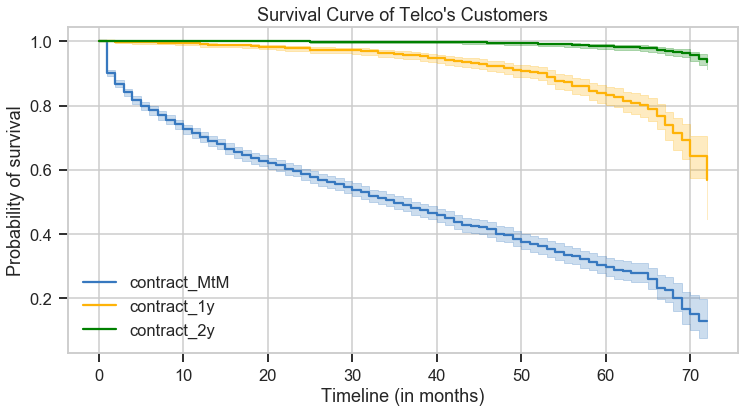

In [86]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['Contract_Month-to-month'] == 1)
contract_1y = (telcom['Contract_One year'] == 1)
contract_2y = (telcom['Contract_Two year'] == 1)
kmf.fit(T[contract_MtM], C[contract_MtM], label='contract_MtM')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[contract_1y], C[contract_1y], label='contract_1y')
ax = kmf.plot(ax=ax, figsize=(12,6))
kmf.fit(T[contract_2y], C[contract_2y], label='contract_2y')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'green')
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

In [87]:
telcom.columns


Index([u'gender', u'SeniorCitizen', u'Partner', u'Dependents', u'tenure',
       u'PhoneService', u'MultipleLines', u'OnlineSecurity', u'OnlineBackup',
       u'DeviceProtection', u'TechSupport', u'StreamingTV', u'StreamingMovies',
       u'PaperlessBilling', u'MonthlyCharges', u'TotalCharges', u'Churn',
       u'InternetService_DSL', u'InternetService_Fiber optic',
       u'InternetService_No', u'Contract_Month-to-month', u'Contract_One year',
       u'Contract_Two year', u'PaymentMethod_Bank transfer (automatic)',
       u'PaymentMethod_Credit card (automatic)',
       u'PaymentMethod_Electronic check', u'PaymentMethod_Mailed check'],
      dtype='object')

In [88]:
dataset.columns


Index([u'gender', u'SeniorCitizen', u'Partner', u'Dependents', u'tenure',
       u'PhoneService', u'MultipleLines', u'InternetService',
       u'OnlineSecurity', u'OnlineBackup', u'DeviceProtection', u'TechSupport',
       u'StreamingTV', u'StreamingMovies', u'Contract', u'PaperlessBilling',
       u'PaymentMethod', u'MonthlyCharges', u'TotalCharges', u'Churn'],
      dtype='object')

Text(0,0.5,'Probability of survival')

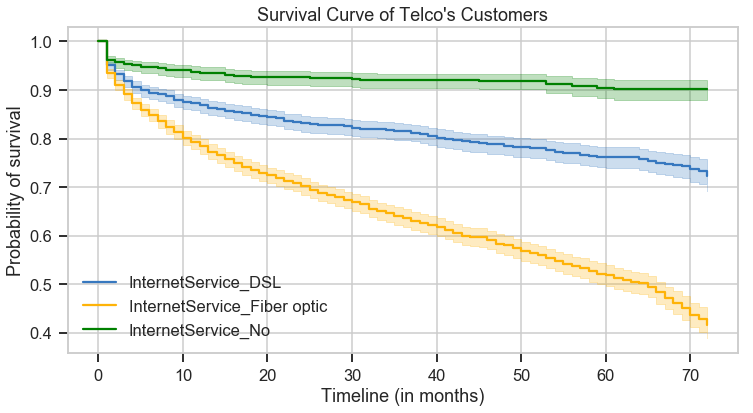

In [90]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['InternetService_DSL'] == 1)
contract_1y = (telcom['InternetService_Fiber optic'] == 1)
contract_2y = (telcom['InternetService_No'] == 1)
kmf.fit(T[contract_MtM], C[contract_MtM], label='InternetService_DSL')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[contract_1y], C[contract_1y], label='InternetService_Fiber optic')
ax = kmf.plot(ax=ax, figsize=(12,6))
kmf.fit(T[contract_2y], C[contract_2y], label='InternetService_No')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'green')
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

Text(0,0.5,'Probability of survival')

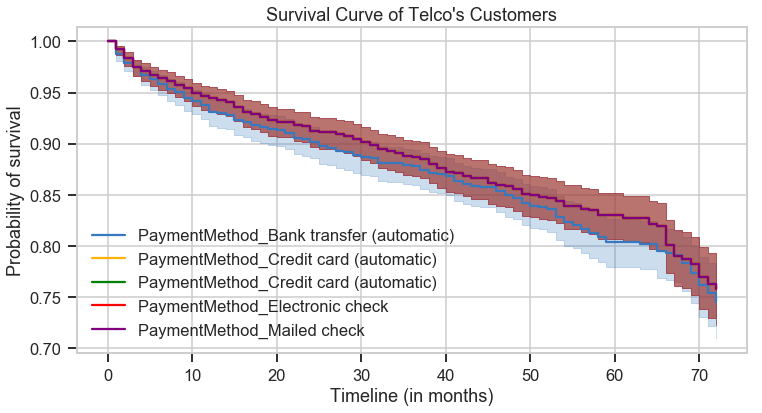

In [91]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['PaymentMethod_Bank transfer (automatic)'] == 1)
contract_1y = (telcom['PaymentMethod_Credit card (automatic)'] == 1)
contract_2y = (telcom['PaymentMethod_Credit card (automatic)'] == 1)
contract_3y = (telcom['PaymentMethod_Electronic check'] == 1)
contract_4y = (telcom['PaymentMethod_Mailed check'] == 1)

kmf.fit(T[contract_MtM], C[contract_MtM], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[contract_1y], C[contract_1y], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax, figsize=(12,6))
kmf.fit(T[contract_2y], C[contract_2y], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'green')
kmf.fit(T[contract_2y], C[contract_2y], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'red')
kmf.fit(T[contract_2y], C[contract_2y], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'purple')
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

Text(0,0.5,'Probability of survival')

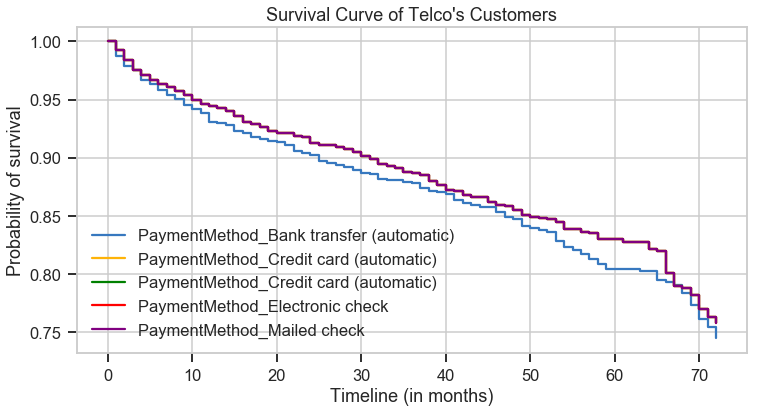

In [92]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['PaymentMethod_Bank transfer (automatic)'] == 1)
contract_1y = (telcom['PaymentMethod_Credit card (automatic)'] == 1)
contract_2y = (telcom['PaymentMethod_Credit card (automatic)'] == 1)
contract_3y = (telcom['PaymentMethod_Electronic check'] == 1)
contract_4y = (telcom['PaymentMethod_Mailed check'] == 1)

kmf.fit(T[contract_MtM], C[contract_MtM], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6), ci_show=False)
kmf.fit(T[contract_1y], C[contract_1y], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax, figsize=(12,6), ci_show=False)
kmf.fit(T[contract_2y], C[contract_2y], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'green', ci_show=False)
kmf.fit(T[contract_2y], C[contract_2y], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'red', ci_show=False)
kmf.fit(T[contract_2y], C[contract_2y], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'purple', ci_show=False)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

Text(0,0.5,'Probability of survival')

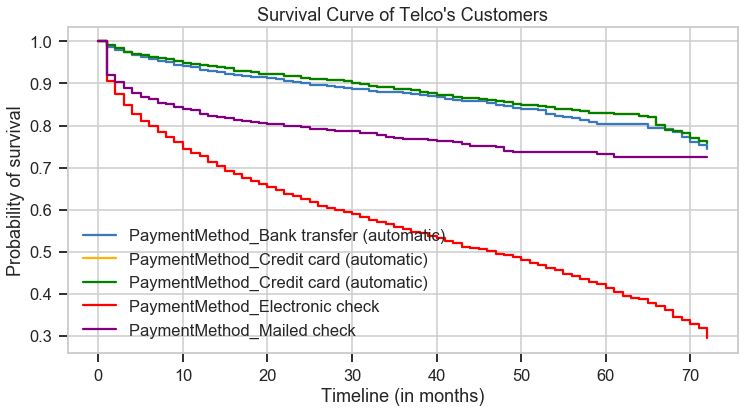

In [93]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['PaymentMethod_Bank transfer (automatic)'] == 1)
contract_1y = (telcom['PaymentMethod_Credit card (automatic)'] == 1)
contract_2y = (telcom['PaymentMethod_Credit card (automatic)'] == 1)
contract_3y = (telcom['PaymentMethod_Electronic check'] == 1)
contract_4y = (telcom['PaymentMethod_Mailed check'] == 1)

kmf.fit(T[contract_MtM], C[contract_MtM], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6), ci_show=False)
kmf.fit(T[contract_1y], C[contract_1y], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax, figsize=(12,6), ci_show=False)
kmf.fit(T[contract_2y], C[contract_2y], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'green', ci_show=False)
kmf.fit(T[contract_3y], C[contract_3y], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'red', ci_show=False)
kmf.fit(T[contract_4y], C[contract_4y], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'purple', ci_show=False)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

Text(0,0.5,'Probability of survival')

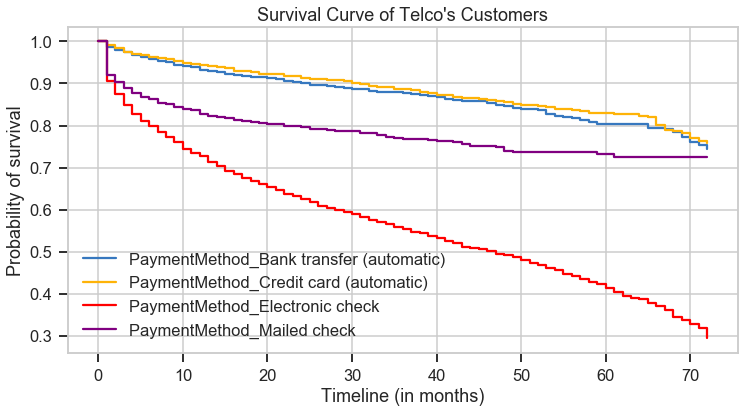

In [94]:
# Survival curves form some multiple categorical groups - Contract 
contract_MtM = (telcom['PaymentMethod_Bank transfer (automatic)'] == 1)
contract_1y = (telcom['PaymentMethod_Credit card (automatic)'] == 1)
contract_3y = (telcom['PaymentMethod_Electronic check'] == 1)
contract_4y = (telcom['PaymentMethod_Mailed check'] == 1)

kmf.fit(T[contract_MtM], C[contract_MtM], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6), ci_show=False)
kmf.fit(T[contract_1y], C[contract_1y], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax, figsize=(12,6), ci_show=False)
kmf.fit(T[contract_3y], C[contract_3y], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'red', ci_show=False)
kmf.fit(T[contract_4y], C[contract_4y], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax, figsize=(12,6), color = 'purple', ci_show=False)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")

Text(0,0.5,'Probability of survival')

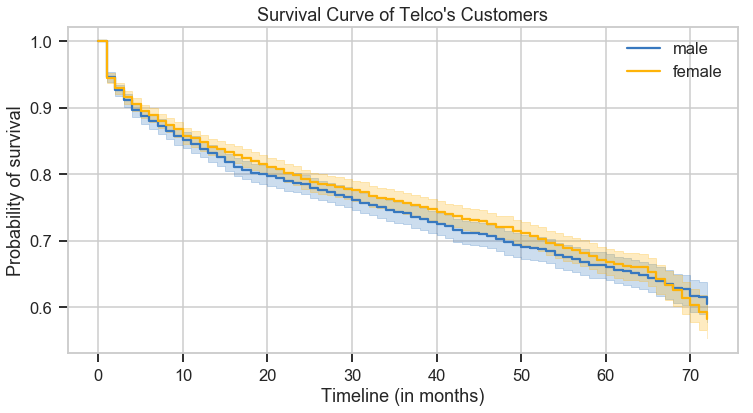

In [95]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.gender == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='male')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='female')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

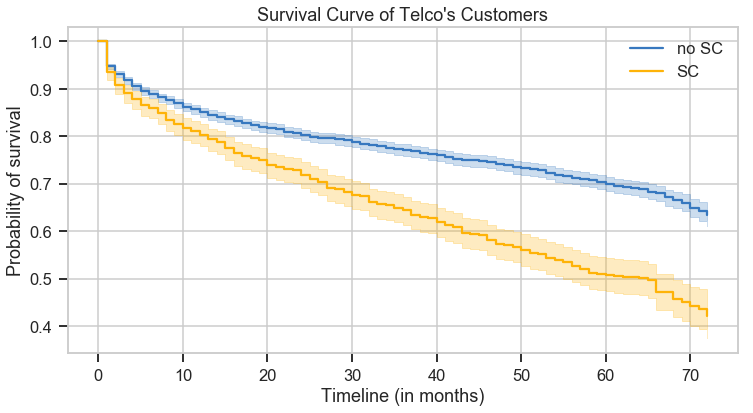

In [96]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.SeniorCitizen == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no SC')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='SC')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

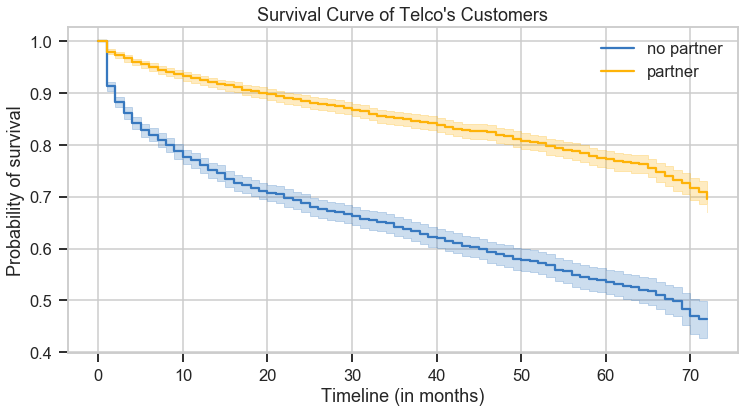

In [97]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Partner == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no partner')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='partner')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

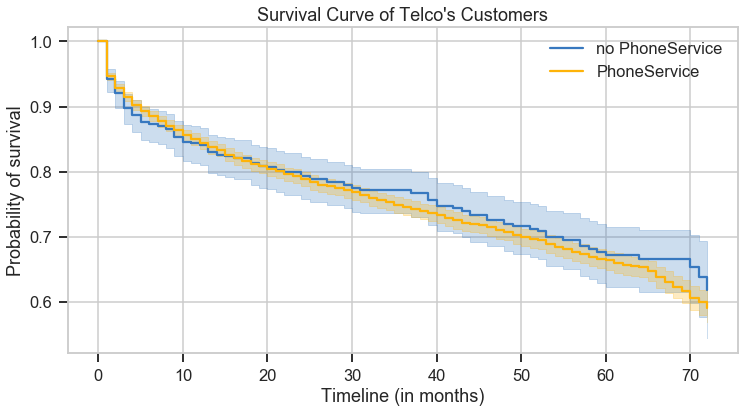

In [98]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PhoneService == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PhoneService')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PhoneService')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

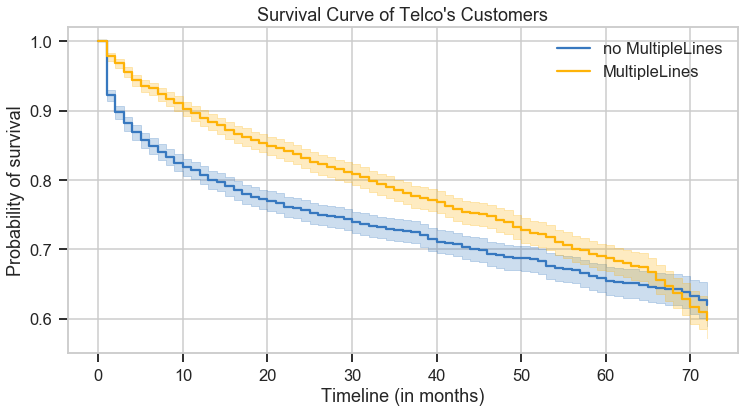

In [99]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.MultipleLines == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no MultipleLines')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='MultipleLines')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

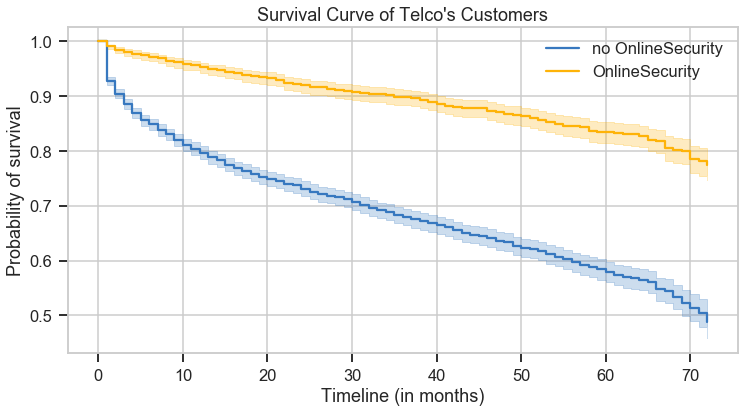

In [100]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.OnlineSecurity == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no OnlineSecurity')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='OnlineSecurity')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

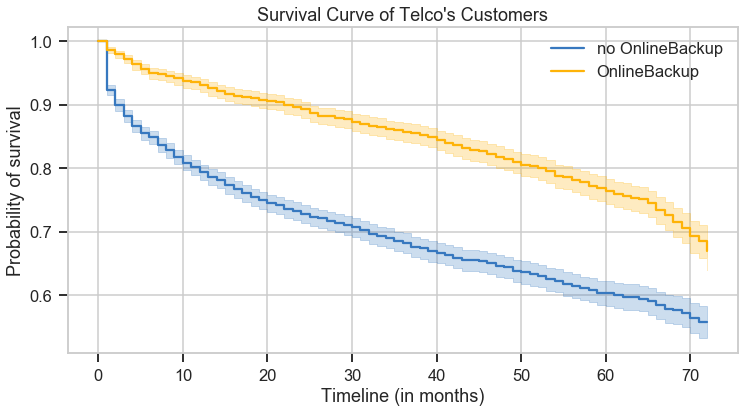

In [101]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.OnlineBackup == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no OnlineBackup')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='OnlineBackup')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

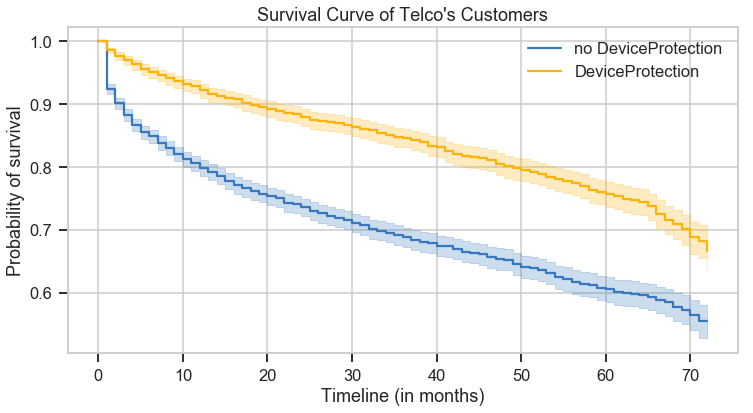

In [102]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.DeviceProtection == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no DeviceProtection')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='DeviceProtection')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

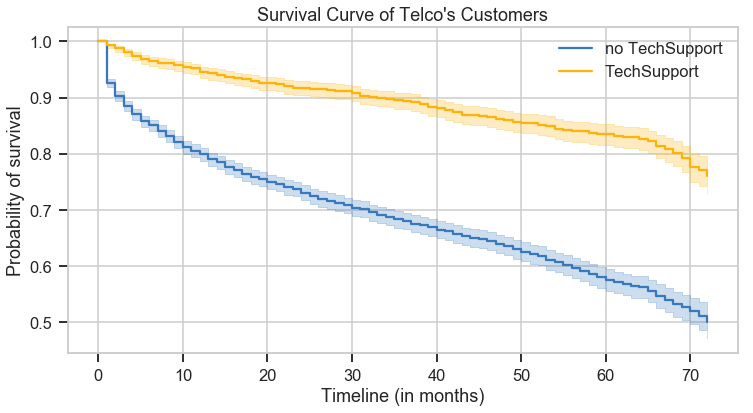

In [103]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.TechSupport == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no TechSupport')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='TechSupport')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

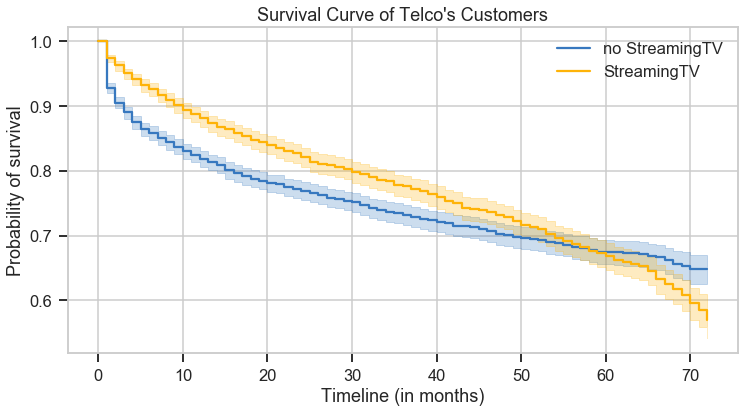

In [104]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.StreamingTV == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no StreamingTV')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='StreamingTV')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

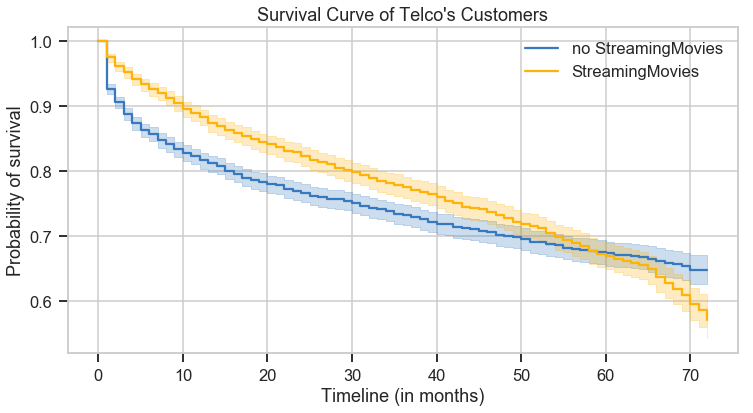

In [105]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.StreamingMovies == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no StreamingMovies')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='StreamingMovies')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

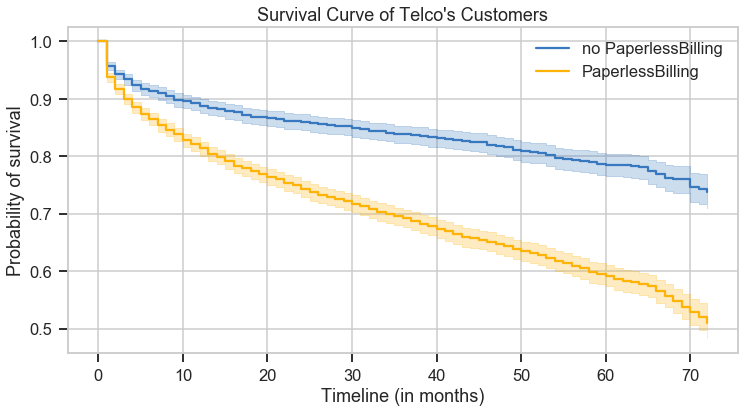

In [106]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaperlessBilling == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaperlessBilling')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaperlessBilling')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

ValueError: zero-size array to reduction operation minimum which has no identity

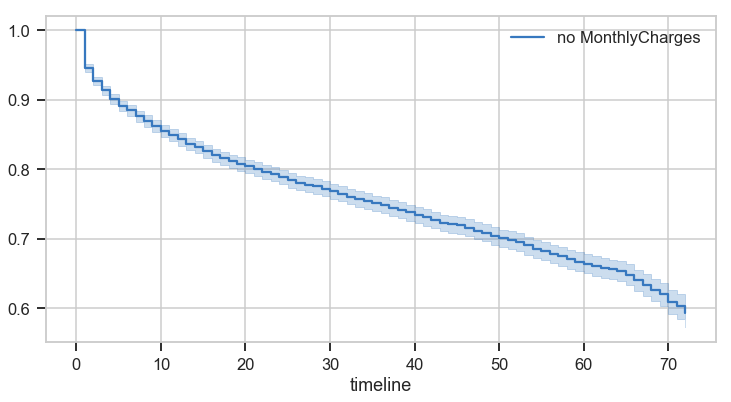

In [107]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.MonthlyCharges == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no MonthlyCharges')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='MonthlyCharges')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

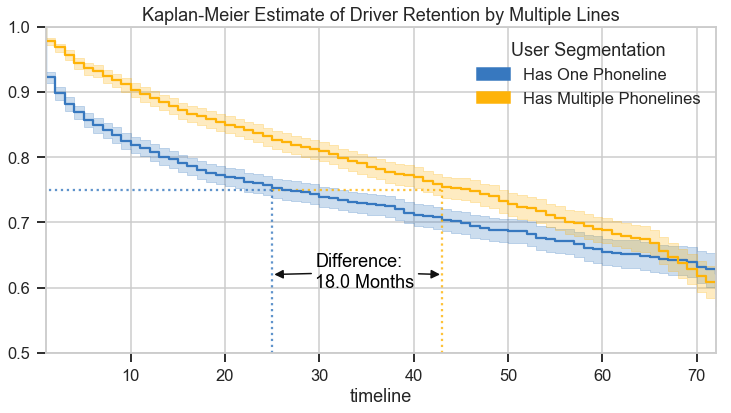

In [108]:
# Improved version mentionned above
# Kaplan Meier estimate of the survival curve, semented by the attribute MultipleLines. 
palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0

##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
for segment in telcom.MultipleLines.unique(): 
    ix = telcom.MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))

    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    
    vlines.append([y_, ymax_])
    i+=1

##PLOT ANNOTATION
#for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

## position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

#label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )

#label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )

##LEGEND
#override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');


          NA_estimate
timeline             
0.0          0.000000
1.0          0.055550
2.0          0.074896
3.0          0.090219
4.0          0.104193


ValueError: zero-size array to reduction operation minimum which has no identity

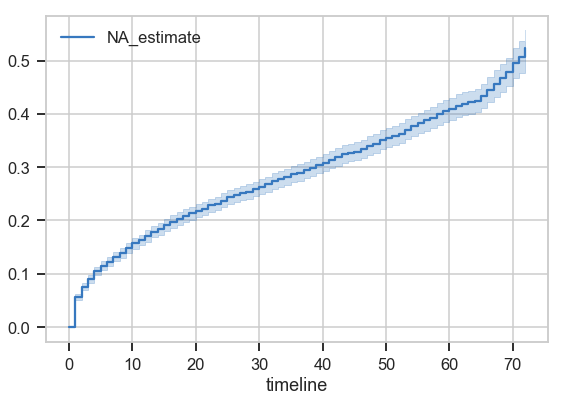

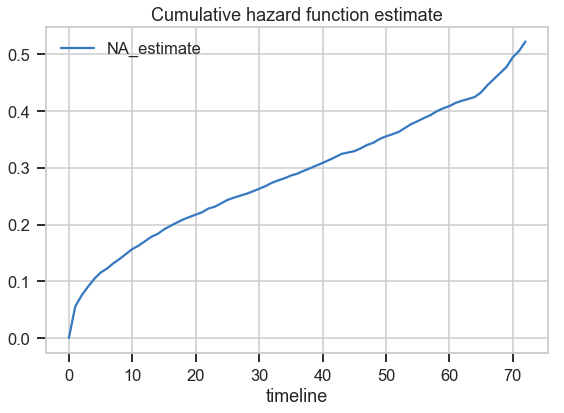

In [109]:
# Hazard function - estimation with Nelson Aalen estimator
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T,event_observed=C)
print(naf.cumulative_hazard_.head())
naf.plot(figsize=(9,6))
naf.cumulative_hazard_.plot(figsize=(9,6))
plt.title('Cumulative hazard function estimate')


# Smoothing hazard function - Dependents
bandwidth = 0.5  #no obvious way to choose this
naf.fit(T[has_dependents], event_observed=C[has_dependents], label="Dependents")
ax = naf.plot_hazard(bandwidth=bandwidth)
naf.fit(T[~has_dependents], event_observed=C[~has_dependents], label="Non-dependents")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)
plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);
plt.ylim(0, 0.4)
plt.xlim(0, 25);

# Statistics on cumulative hazard function plotted
print(naf.confidence_interval_)

In [110]:
has_dependents = (telcom.Dependents == 1)

          NA_estimate
timeline             
0.0          0.000000
1.0          0.055550
2.0          0.074896
3.0          0.090219
4.0          0.104193
      Non-dependents_upper_0.95  Non-dependents_lower_0.95
0.0                    0.000000                   0.000000
1.0                    0.075287                   0.060510
2.0                    0.102575                   0.084985
3.0                    0.123207                   0.103667
4.0                    0.139646                   0.118625
5.0                    0.155006                   0.132645
6.0                    0.164390                   0.141228
7.0                    0.177092                   0.152863
8.0                    0.187519                   0.162426
9.0                    0.199393                   0.173327
10.0                   0.211899                   0.184818
11.0                   0.220026                   0.192290
12.0                   0.229618                   0.201110
13.0                

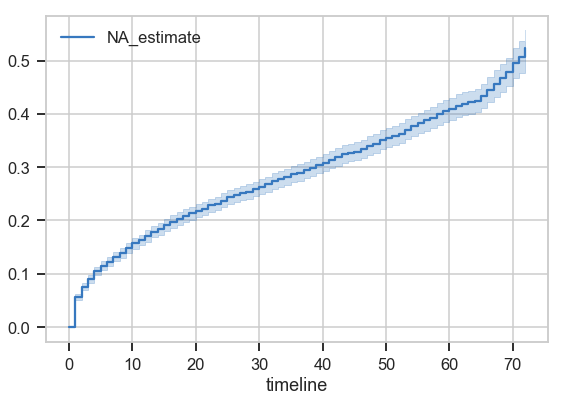

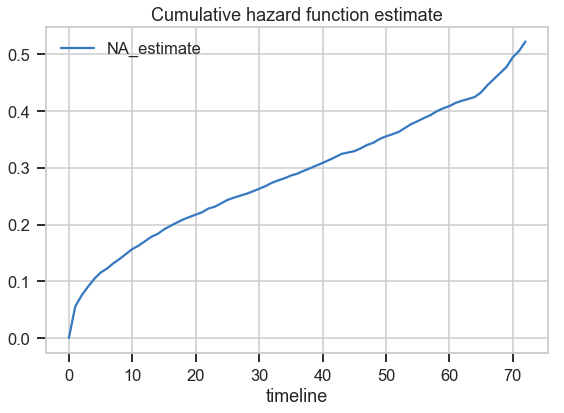

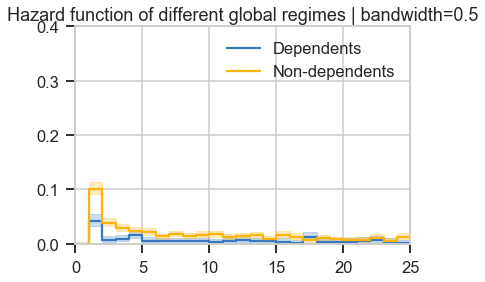

In [111]:


# Hazard function - estimation with Nelson Aalen estimator
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T,event_observed=C)
print(naf.cumulative_hazard_.head())
naf.plot(figsize=(9,6))
naf.cumulative_hazard_.plot(figsize=(9,6))
plt.title('Cumulative hazard function estimate')


# Smoothing hazard function - Dependents
bandwidth = 0.5  #no obvious way to choose this
naf.fit(T[has_dependents], event_observed=C[has_dependents], label="Dependents")
ax = naf.plot_hazard(bandwidth=bandwidth)
naf.fit(T[~has_dependents], event_observed=C[~has_dependents], label="Non-dependents")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)
plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);
plt.ylim(0, 0.4)
plt.xlim(0, 25);

# Statistics on cumulative hazard function plotted
print(naf.confidence_interval_)



In [112]:
# Import library 
# log rank test to approximate hazard ratios. Log rank test's hypothesis is that hazard of 2 groups are the same at a any point in time (hazard ratio = 1)
# We then use the logrank statistic obtain to compute the true hazard ratio. 
from lifelines.statistics import logrank_test


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["gender"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by the variable Dependents. 
has_dependents = (telcom['Dependents'] == 1)
res_has_dependents = logrank_test(T[has_dependents], T[~has_dependents], C[has_dependents], C[~has_dependents],  alpha=0.95)
res_has_dependents.print_summary()
print('p_value', res_has_dependents.p_value) # we reject the hypothesis. Event rates are not the same for indiv with and without dependents.  
# Hazard ratio - No need here - won't be relevant because curves cross!  
Z = res_has_dependents.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio)
# 4731 --> not relevant (because curves might cross) 


<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic    p  -log2(p)
          0.53 0.47      1.09
1.0246184594675596
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        232.70 <0.005    172.12
('p_value', 1.5372382701500785e-52)
47341.68070828688


In [113]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["Dependents"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        232.70 <0.005    172.12
47341.68070828688


In [114]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["SeniorCitizen"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        109.49 <0.005     82.71
158.4157913120195


In [115]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["Partner"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        423.54 <0.005    310.21
323268072.40851897


In [116]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["PhoneService"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic    p  -log2(p)
          0.43 0.51      0.97
1.02013051316573


In [117]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["MultipleLines"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
         24.85 <0.005     20.62
3.157035574094717


In [118]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["OnlineSecurity"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        367.17 <0.005    269.45
23821006.91235937


In [119]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom['OnlineBackup'] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        196.62 <0.005    145.98
8921.655767946448


In [120]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["StreamingTV"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic    p  -log2(p)
          4.09 0.04      4.53
1.2081918483920897


In [121]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["StreamingMovies"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic    p  -log2(p)
          5.33 0.02      5.57
1.2794203859603013


In [122]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["DeviceProtection"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        167.21 <0.005    124.64
2288.211090256669


In [123]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["TechSupport"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        349.00 <0.005    256.30
10277718.134087097


In [124]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["PaperlessBilling"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        189.51 <0.005    140.82
6420.166684568746


In [125]:
telcom.columns

Index([u'gender', u'SeniorCitizen', u'Partner', u'Dependents', u'tenure',
       u'PhoneService', u'MultipleLines', u'OnlineSecurity', u'OnlineBackup',
       u'DeviceProtection', u'TechSupport', u'StreamingTV', u'StreamingMovies',
       u'PaperlessBilling', u'MonthlyCharges', u'TotalCharges', u'Churn',
       u'InternetService_DSL', u'InternetService_Fiber optic',
       u'InternetService_No', u'Contract_Month-to-month', u'Contract_One year',
       u'Contract_Two year', u'PaymentMethod_Bank transfer (automatic)',
       u'PaymentMethod_Credit card (automatic)',
       u'PaymentMethod_Electronic check', u'PaymentMethod_Mailed check'],
      dtype='object')

In [126]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["InternetService_Fiber optic"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 




<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        477.08 <0.005    348.92
3847089566.392712


In [127]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["InternetService_Fiber optic"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["InternetService_No"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["InternetService_DSL"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["Contract_Month-to-month"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["Contract_One year"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["Contract_Two year"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        477.08 <0.005    348.92
3847089566.392712
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        251.20 <0.005    185.52
111403.30232611122
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
         86.44 <0.005     65.91
54.53005722707574
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
       2304.22 <0.005       inf
1.9719553113588143e+46
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1

In [128]:
# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["PaymentMethod_Bank transfer (automatic)"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["PaymentMethod_Credit card (automatic)"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["PaymentMethod_Electronic check"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


# Compare hazards of two groups of individuals, segmented by their gender
gender_male = (telcom["PaymentMethod_Mailed check"] == 1)
res_gender = logrank_test(T[gender_male], T[~gender_male], C[gender_male], C[~gender_male], alpha=0.95 ) #at 95% confidence level
res_gender.print_summary() # p value of 0.47, don't reject the null hypothesis. Hazard can be equal across two groups at any point in time. 
# Compute hazard ratio from log rank test
Z = res_gender.test_statistic
D = C.sum() #number of events observed
hazard_ratio = np.exp(Z*np.sqrt(4.0/D))
print(hazard_ratio) # hazard ratio of 1.025! death rates are the same at any point in time for both groups. gender has no impact. 


<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        178.66 <0.005    132.95
3886.6022303294
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        203.63 <0.005    151.06
12339.395984557508
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
        803.75 <0.005    584.93
1.407273987047679e+16
<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
               t_0 = -1
 null_distribution = chi squared

---
test_statistic    p  -log2(p)
          1.43 0.23      2.11
1.0682099991646108


In [129]:
telcom[telcom.columns]

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
5          0              0        0           0       8             1   
6          1              0        0           1      22             1   
7          0              0        0           0      10             0   
8          0              0        1           0      28             1   
9          1              0        0           1      62             1   
10         1              0        1           1      13             1   
11         1              0        0           0      16             1   
12         1              0        1           0      58             1   
13         1              0        0           0      49             1   
14         1              0        0           0      25             1   
15         0              0        1           1      69             1   
16         0              0        0           0      52             1   
17         1              0        0           1      71             1   
18         0              0        1           1      10             1   
19         0              0        0           0      21             1   
20         1              1        0           0       1             0   
21         1              0        1           0      12             1   
22         1              0        0           0       1             1   
23         0              0        1           0      58             1   
24         1              0        1           1      49             1   
25         0              0        0           0      30             1   
26         1              0        1           1      47             1   
27         1              0        1           1       1             0   
28         1              0        1           0      72             1   
29         0              0        0           1      17             1   
...      ...            ...      ...         ...     ...           ...   
7002       0              0        0           0      40             1   
7003       1              0        0           0      41             1   
7004       1              1        1           0      34             1   
7005       0              0        0           0       1             1   
7006       0              0        0           0      51             1   
7007       1              0        1           1       1             1   
7008       0              0        0           0      39             1   
7009       1              0        1           1      12             1   
7010       1              0        0           0      12             1   
7011       1              0        0           0      72             1   
7012       0              1        1           0      63             1   
7013       1              0        1           0      44             1   
7014       0              0        0           0      18             1   
7015       0              0        0           0       9             1   
7016       1              0        0           0      13             1   
7017       0              0        1           0      68             1   
7018       0              1        0           0       6             0   
7019       0              0        0           0       2             1   
7020       1              1        1           0      55             1   
7021       1              1        0           0       1             1   
7022       1              0        0           0      38             1   
7023       0              0        0           0      67             1   
7024      

In [130]:
telcom.columns

Index([u'gender', u'SeniorCitizen', u'Partner', u'Dependents', u'tenure',
       u'PhoneService', u'MultipleLines', u'OnlineSecurity', u'OnlineBackup',
       u'DeviceProtection', u'TechSupport', u'StreamingTV', u'StreamingMovies',
       u'PaperlessBilling', u'MonthlyCharges', u'TotalCharges', u'Churn',
       u'InternetService_DSL', u'InternetService_Fiber optic',
       u'InternetService_No', u'Contract_Month-to-month', u'Contract_One year',
       u'Contract_Two year', u'PaymentMethod_Bank transfer (automatic)',
       u'PaymentMethod_Credit card (automatic)',
       u'PaymentMethod_Electronic check', u'PaymentMethod_Mailed check'],
      dtype='object')

In [132]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.InternetService_DSL == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_DSL')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_DSL')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.(InternetService_Fiber optic) == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_Fiber optic')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_Fiber optic')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.InternetService_No == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_No')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_No')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_Month-to-month == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Month-to-month')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Month-to-month')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_One year == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_One year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_One year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_Two year == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Two year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Two year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Bank transfer (automatic) == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Credit card (automatic) == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Credit card (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Electronic check == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Electronic check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Mailed check == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Mailed check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below


SyntaxError: invalid syntax (<ipython-input-132-233216862d42>, line 13)

In [133]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.InternetService_DSL == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_DSL')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_DSL')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.(InternetService_Fiber optic) == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_Fiber optic')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_Fiber optic')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.InternetService_No == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_No')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_No')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_Month-to-month == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Month-to-month')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Month-to-month')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_One year == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_One year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_One year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_Two year == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Two year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Two year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Bank transfer (automatic) == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Credit card (automatic) == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Credit card (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Electronic check == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Electronic check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Mailed check == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Mailed check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

SyntaxError: invalid syntax (<ipython-input-133-233216862d42>, line 13)

In [134]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.InternetService_DSL == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_DSL')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_DSL')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below


# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.InternetService_No == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_No')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_No')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_Month-to-month == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Month-to-month')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Month-to-month')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_One year == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_One year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_One year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.Contract_Two year == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Two year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Two year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Bank transfer (automatic) == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Credit card (automatic) == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Credit card (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Electronic check == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Electronic check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.PaymentMethod_Mailed check == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Mailed check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

SyntaxError: invalid syntax (<ipython-input-134-8545f2afab42>, line 36)

In [135]:
telcom.Contract_One year

SyntaxError: invalid syntax (<ipython-input-135-04fe3379dd98>, line 1)

KeyError: 'PaymentMethod_Bank transfer (automatic'

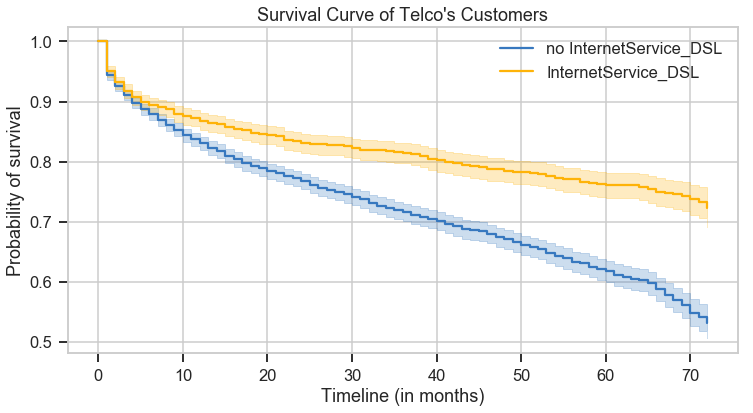

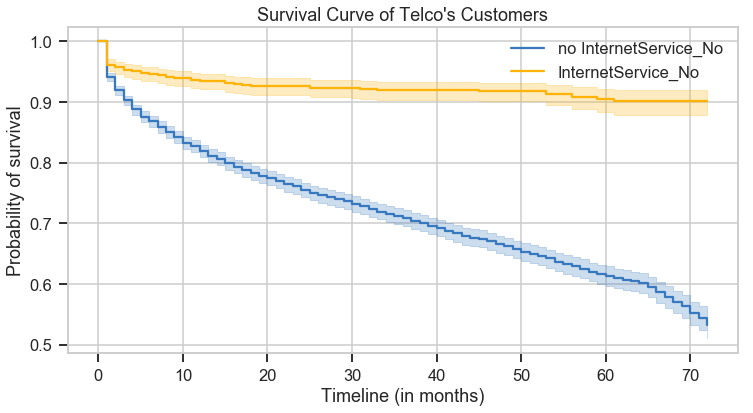

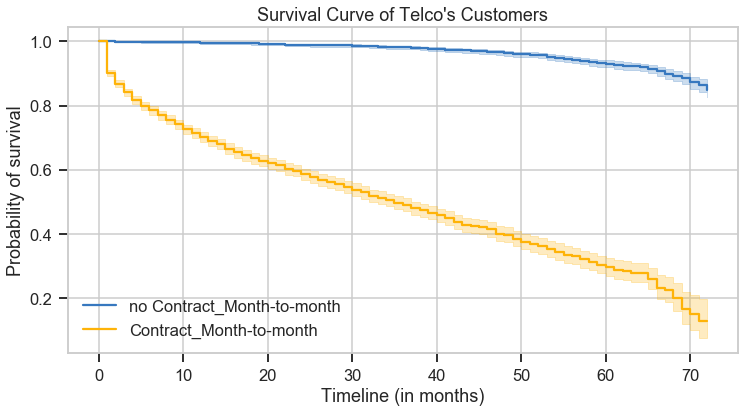

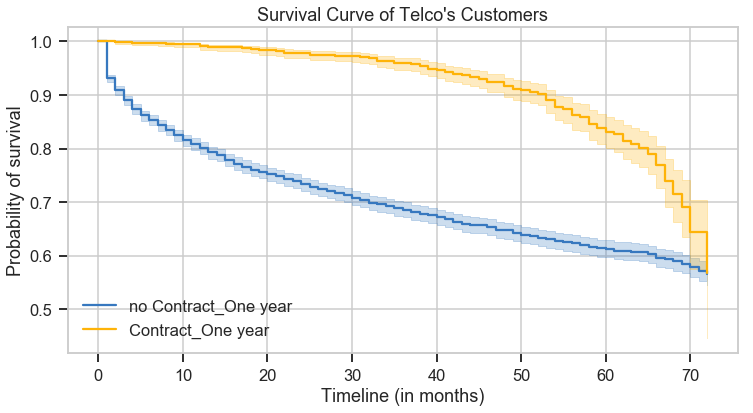

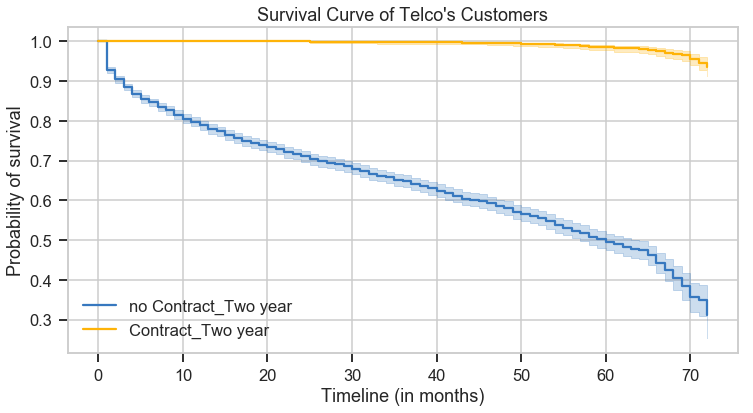

In [136]:


# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["InternetService_DSL"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_DSL')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_DSL')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below


# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["InternetService_No"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_No')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_No')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["Contract_Month-to-month"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Month-to-month')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Month-to-month')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["Contract_One year"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_One year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_One year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["Contract_Two year"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Two year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Two year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["PaymentMethod_Bank transfer (automatic"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["PaymentMethod_Credit card (automatic)"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Credit card (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["PaymentMethod_Electronic check"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Electronic check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["PaymentMethod_Mailed check"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Mailed check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

Text(0,0.5,'Probability of survival')

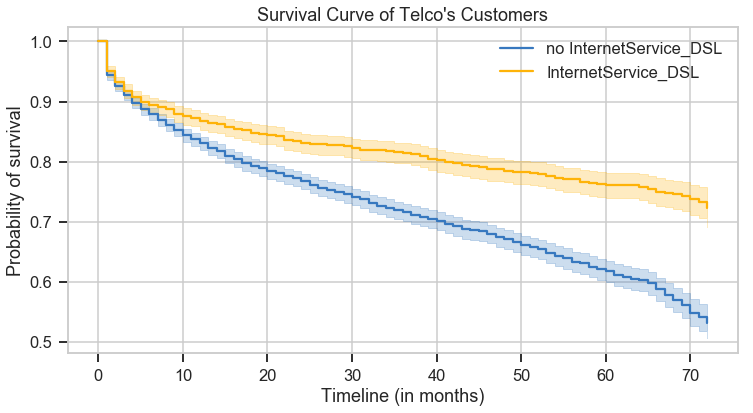

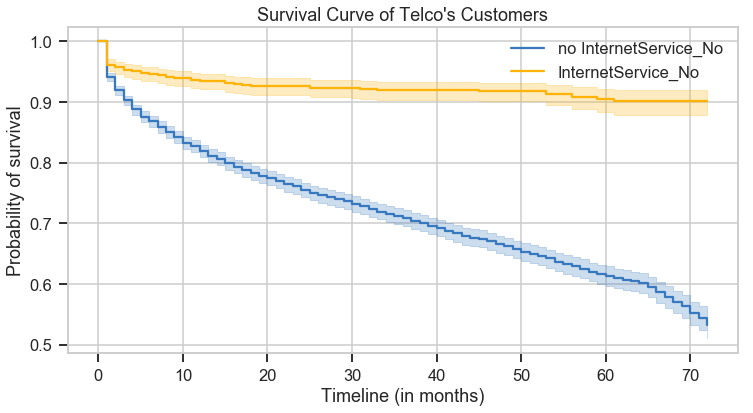

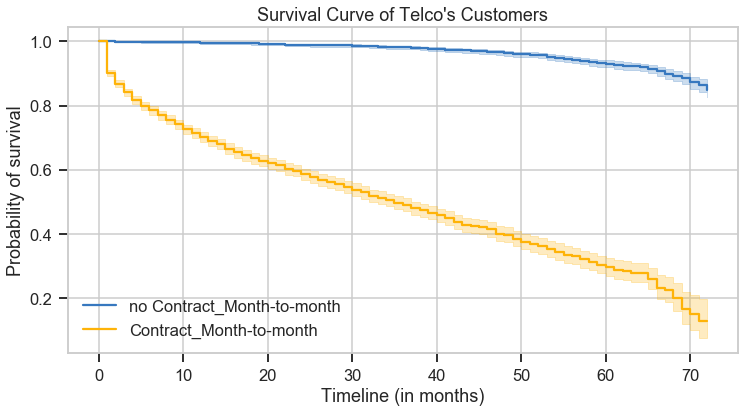

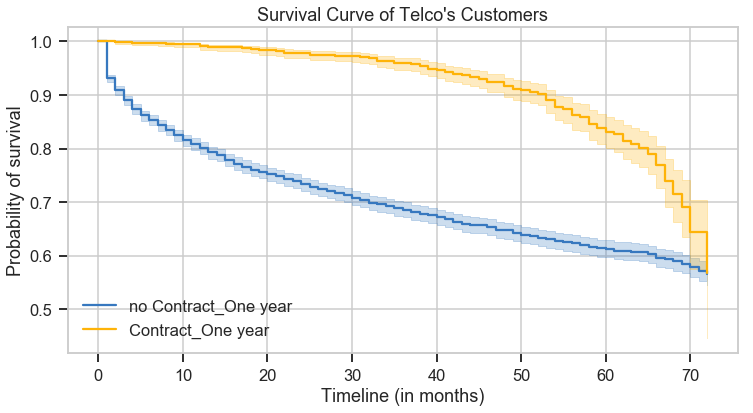

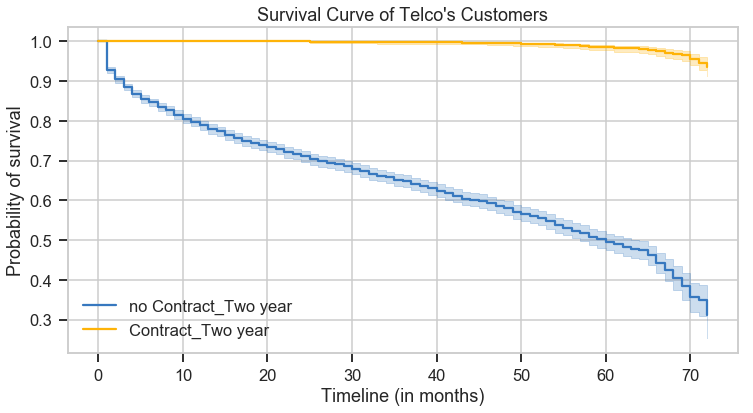

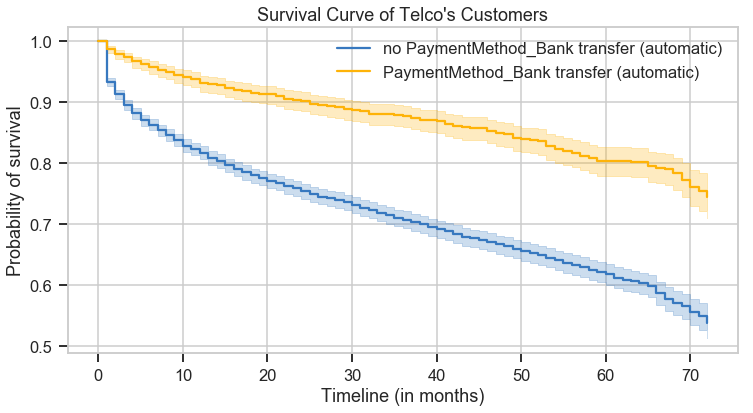

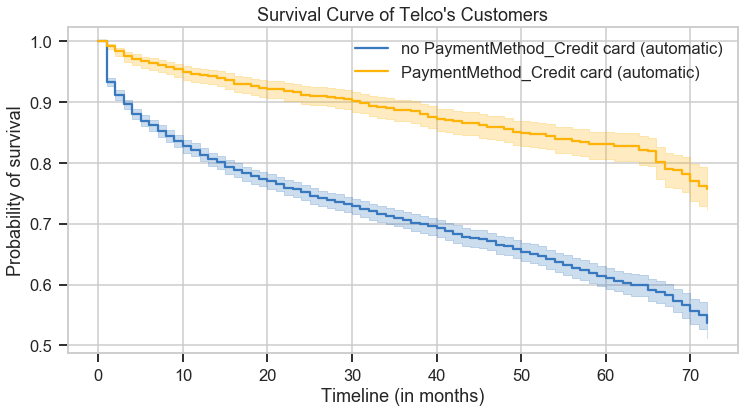

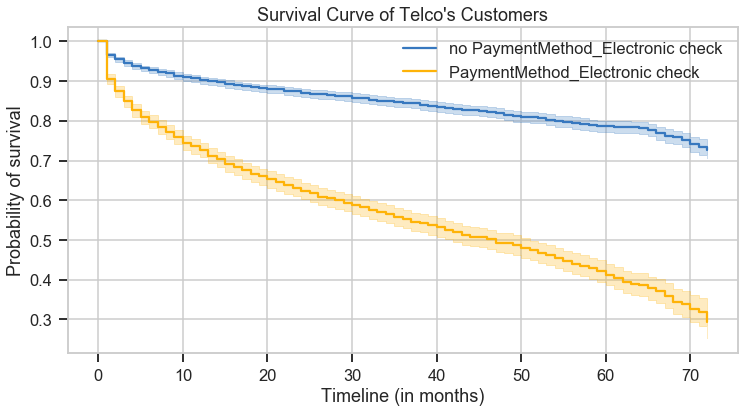

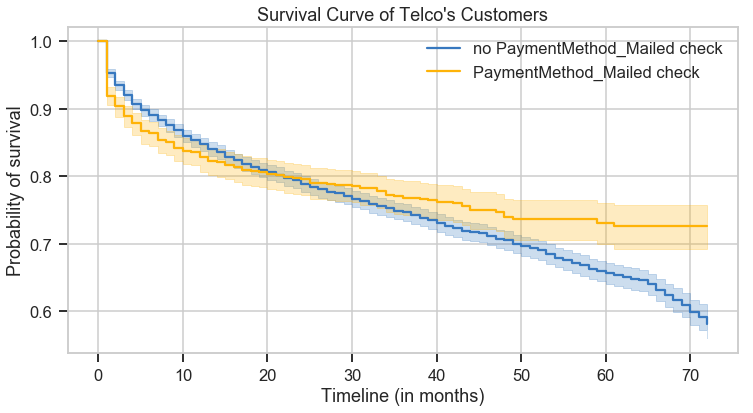

In [137]:


# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["InternetService_DSL"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_DSL')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_DSL')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below


# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["InternetService_No"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no InternetService_No')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='InternetService_No')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["Contract_Month-to-month"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Month-to-month')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Month-to-month')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["Contract_One year"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_One year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_One year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["Contract_Two year"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no Contract_Two year')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='Contract_Two year')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["PaymentMethod_Bank transfer (automatic)"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Bank transfer (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["PaymentMethod_Credit card (automatic)"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Credit card (automatic)')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Credit card (automatic)')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["PaymentMethod_Electronic check"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Electronic check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Electronic check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

# Survival curves for some groups - Here Dependents 
has_dependents = (telcom["PaymentMethod_Mailed check"] == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PaymentMethod_Mailed check')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PaymentMethod_Mailed check')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below


<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
 null_distribution = chi squared
     point_in_time = 10

---
test_statistic    p  -log2(p)
          4.29 0.04      4.70
<lifelines.StatisticalResult>
degrees_of_freedom = 2
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
       2352.87 <0.005       inf
('p_value', 0.0)


AttributeError: 'ExponentialFitter' object has no attribute 'plot_hazard_function'

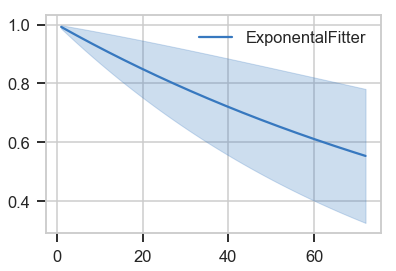

In [138]:
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
surv_diff = survival_difference_at_fixed_point_in_time_test(10, T[has_dependents], T[~has_dependents], C[has_dependents], C[~has_dependents],  alpha=0.95)
surv_diff.print_summary()


# Log rank test 
# For multivariate categorical variable - Contract
from lifelines.statistics import multivariate_logrank_test
res_contract = multivariate_logrank_test(telcom['tenure'], dataset['Contract'], telcom['Churn'])
res_contract.print_summary()
print('p_value', res_contract.p_value) # p value lower than 0.05
# This means that hazard rates are different for Contract_MtM, 1year and 2years subscribers. 



# Exponential Fitter / model
from lifelines import ExponentialFitter
exf = ExponentialFitter().fit(T, C, label='ExponentalFitter')
exf.plot_survival_function()
exf.plot_hazard_function()

# Weibull estimator
from lifelines import WeibullFitter
wbf = WeibullFitter().fit(T, C, label='WeibullFitter')
wbf.plot_survival_function()

In [139]:
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
surv_diff = survival_difference_at_fixed_point_in_time_test(10, T[has_dependents], T[~has_dependents], C[has_dependents], C[~has_dependents],  alpha=0.95)
surv_diff.print_summary()


# Log rank test 
# For multivariate categorical variable - Contract
from lifelines.statistics import multivariate_logrank_test
res_contract = multivariate_logrank_test(telcom['tenure'], dataset['Contract'], telcom['Churn'])
res_contract.print_summary()
print('p_value', res_contract.p_value) # p value lower than 0.05
# This means that hazard rates are different for Contract_MtM, 1year and 2years subscribers. 



<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
 null_distribution = chi squared
     point_in_time = 10

---
test_statistic    p  -log2(p)
          4.29 0.04      4.70
<lifelines.StatisticalResult>
degrees_of_freedom = 2
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
       2352.87 <0.005       inf
('p_value', 0.0)


In [140]:
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
surv_diff = survival_difference_at_fixed_point_in_time_test(10, T[has_dependents], T[~has_dependents], C[has_dependents], C[~has_dependents],  alpha=0.95)
surv_diff.print_summary()

<lifelines.StatisticalResult>
degrees_of_freedom = 1
             alpha = 0.95
 null_distribution = chi squared
     point_in_time = 10

---
test_statistic    p  -log2(p)
          4.29 0.04      4.70


In [141]:
print(surv_diff)

<lifelines.StatisticalResult>


In [142]:
# Log rank test 
# For multivariate categorical variable - Contract
from lifelines.statistics import multivariate_logrank_test
res_contract = multivariate_logrank_test(telcom['tenure'], dataset['Contract'], telcom['Churn'])
res_contract.print_summary()
print('p_value', res_contract.p_value) # p value lower than 0.05
# This means that hazard rates are different for Contract_MtM, 1year and 2years subscribers. 


<lifelines.StatisticalResult>
degrees_of_freedom = 2
               t_0 = -1
 null_distribution = chi squared

---
test_statistic      p  -log2(p)
       2352.87 <0.005       inf
('p_value', 0.0)


AttributeError: 'ExponentialFitter' object has no attribute 'plot_hazard_function'

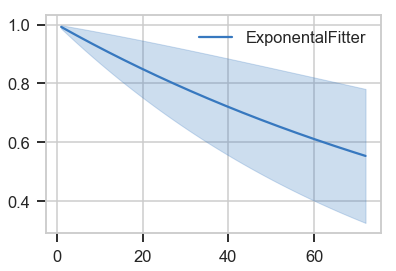

In [143]:
# Exponential Fitter / model
from lifelines import ExponentialFitter
exf = ExponentialFitter().fit(T, C, label='ExponentalFitter')
exf.plot_survival_function()
exf.plot_hazard_function()

# Weibull estimator
from lifelines import WeibullFitter
wbf = WeibullFitter().fit(T, C, label='WeibullFitter')
wbf.plot_survival_function()


(0, 75)

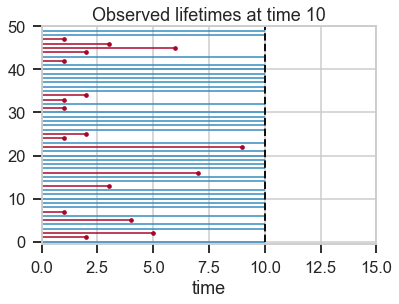

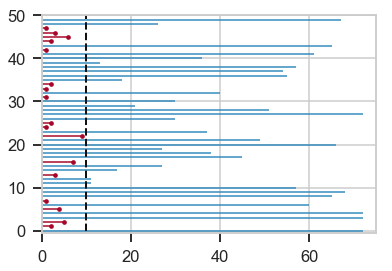

In [144]:
# Import libraries
from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 10
N =50
random_subset = telcom.sample(N, random_state = 44) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)
ax.set_xlim(0, CURRENT_TIME +5)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )


# Same but view where each customer churns 
N=75
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, N)


Text(0.5,1,'Observed lifetimes at time 40')

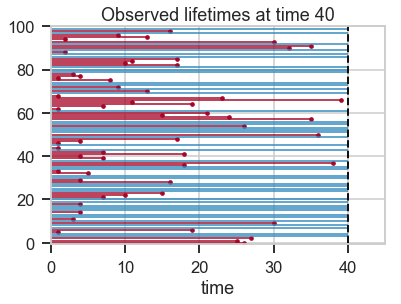

In [145]:
# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 100
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)
ax.set_xlim(0, CURRENT_TIME +5)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )


Text(0.5,1,'Observed lifetimes at time 40')

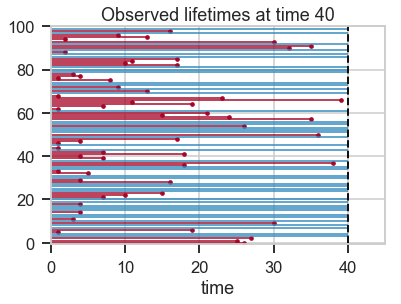

In [146]:
# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 100
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed, figsize=(10,12))
ax.set_xlim(0, CURRENT_TIME +5)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 40')

<Figure size 576x576 with 0 Axes>

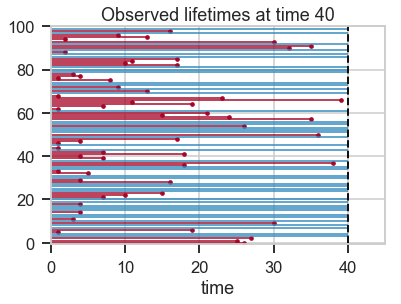

In [147]:
# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 100
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(8,8))
ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)
ax.set_xlim(0, CURRENT_TIME +5)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 40')

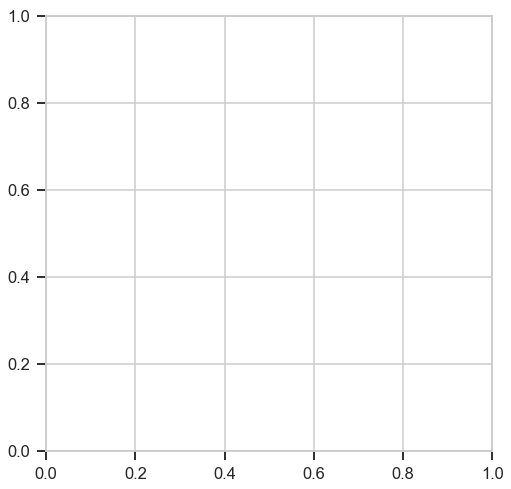

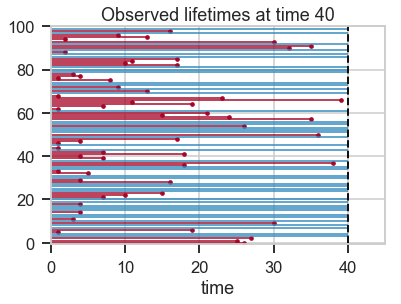

In [148]:
# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 100
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(8,8))
plt.subplot()
ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)
ax.set_xlim(0, CURRENT_TIME +5)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

In [149]:
# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 100
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(8,8))
plt.subplot(ax)
ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)
ax.set_xlim(0, CURRENT_TIME +5)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

ValueError: The Subplot must have been created in the present figure

<Figure size 576x576 with 0 Axes>

Text(0.5,1,'Observed lifetimes at time 40')

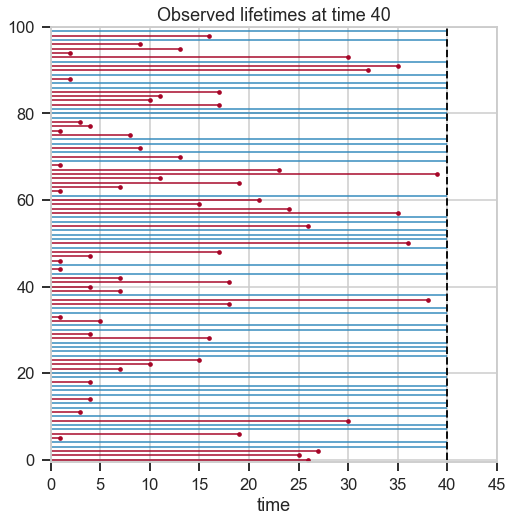

In [150]:
# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 100
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(8,8))
bx= plt.subplot()
ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed, ax=bx)
ax.set_xlim(0, CURRENT_TIME +5)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

In [151]:
N=100
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, N)

(0, 100)

Text(0.5,1,'Observed lifetimes at time 40')

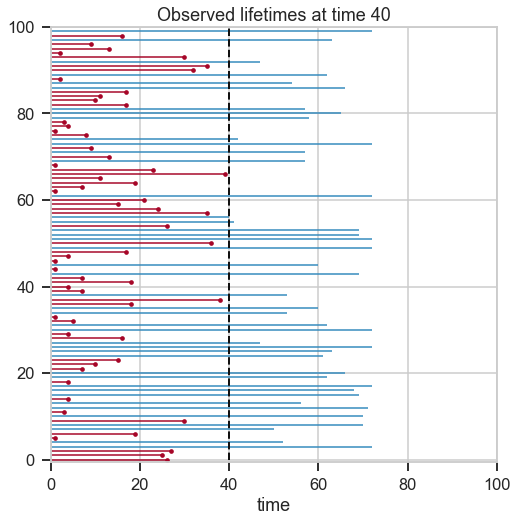

In [152]:
# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 100
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(8,8))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, N)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 40')

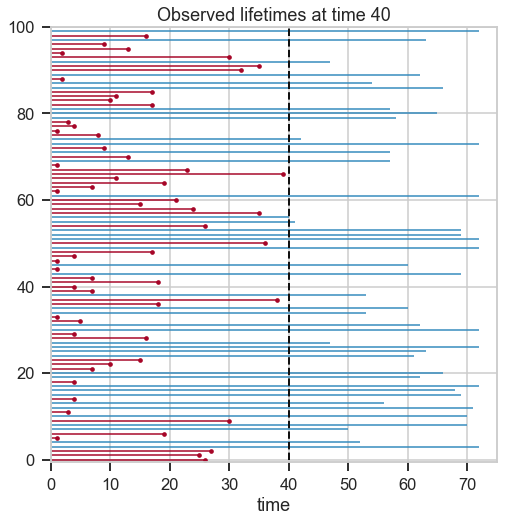

In [153]:
# Representation of censoring for a random sample of the dataset
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 100
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(8,8))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 40')

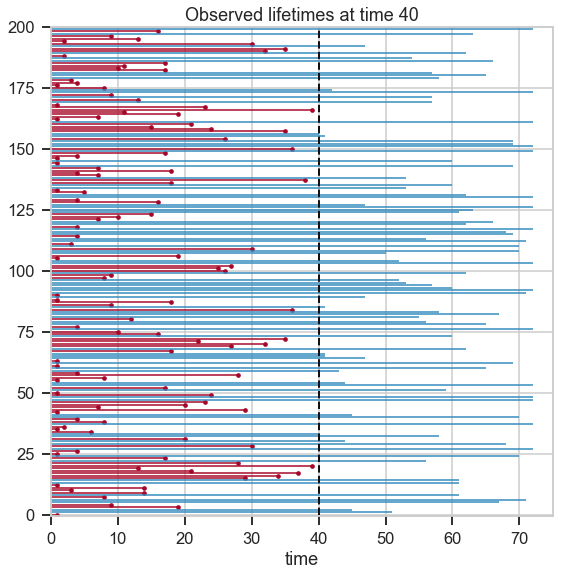

In [154]:
CURRENT_TIME = 40  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 60')

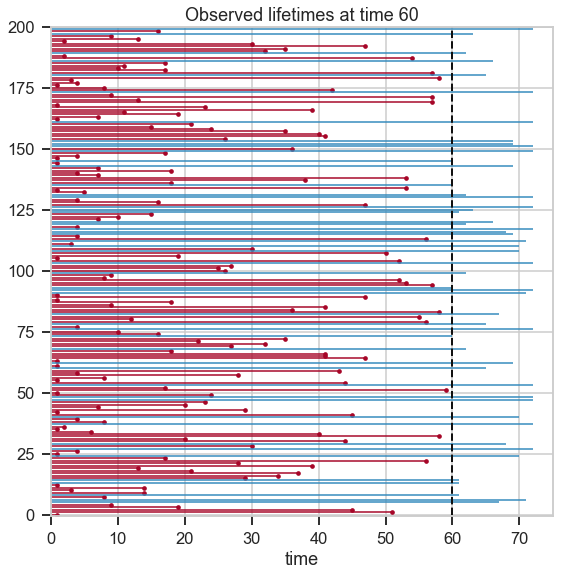

In [155]:
CURRENT_TIME = 60  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 71')

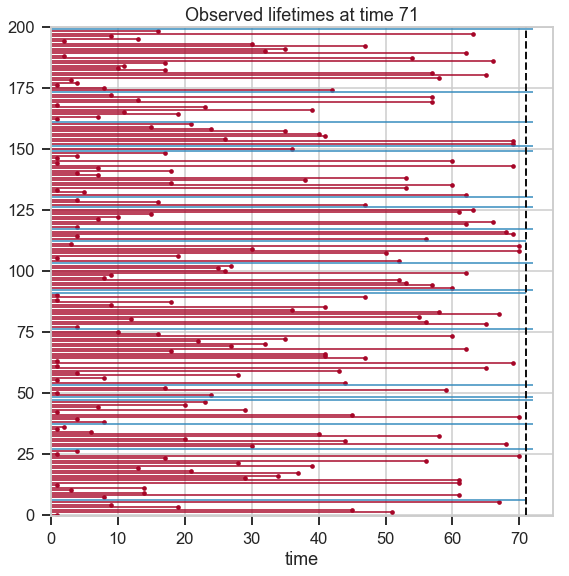

In [156]:
CURRENT_TIME = 71  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 69')

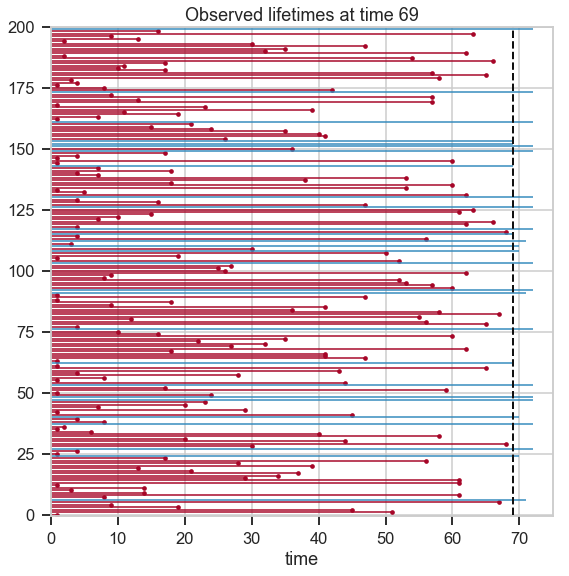

In [157]:
CURRENT_TIME = 69  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 3')

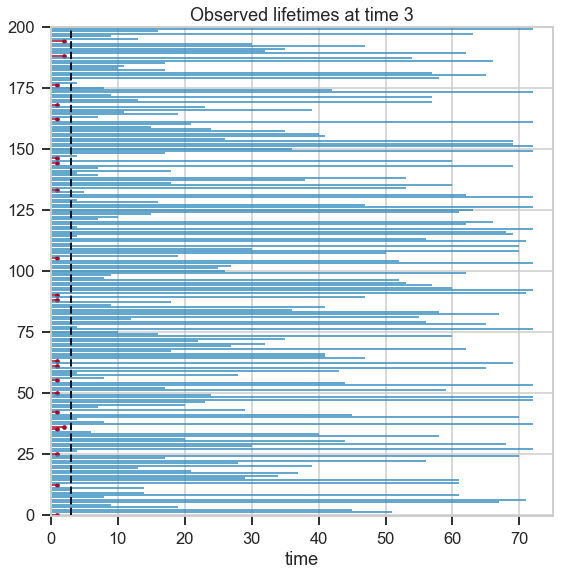

In [158]:
CURRENT_TIME = 3  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 1')

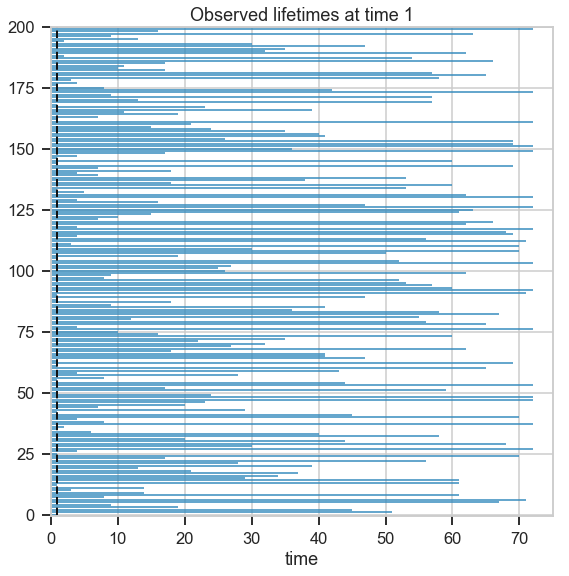

In [159]:
CURRENT_TIME = 1  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 2')

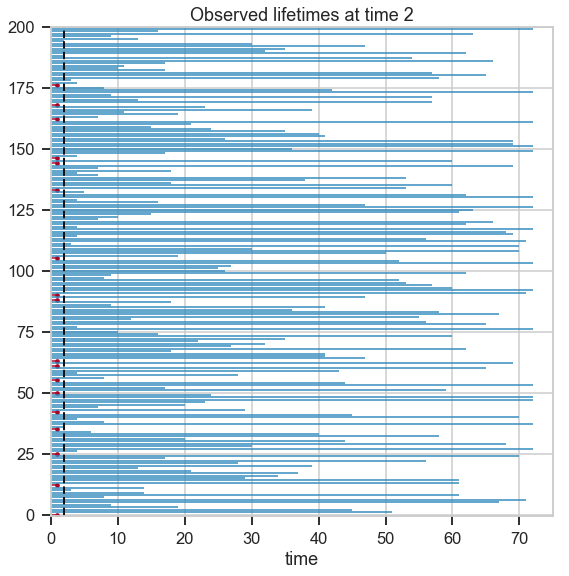

In [160]:
CURRENT_TIME = 2  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 62')

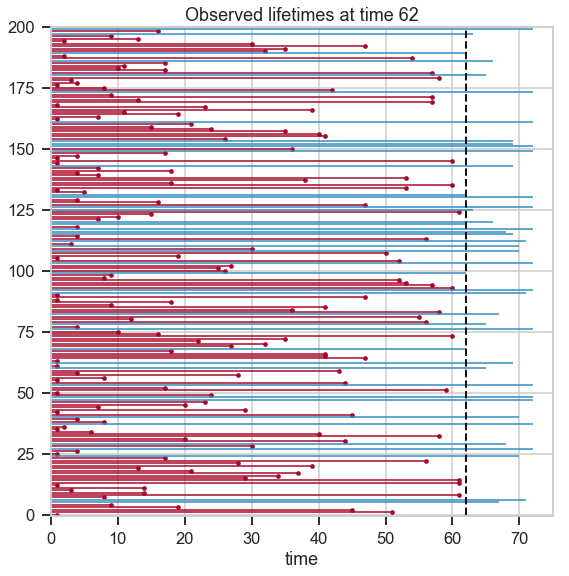

In [161]:
CURRENT_TIME = 62  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 24')

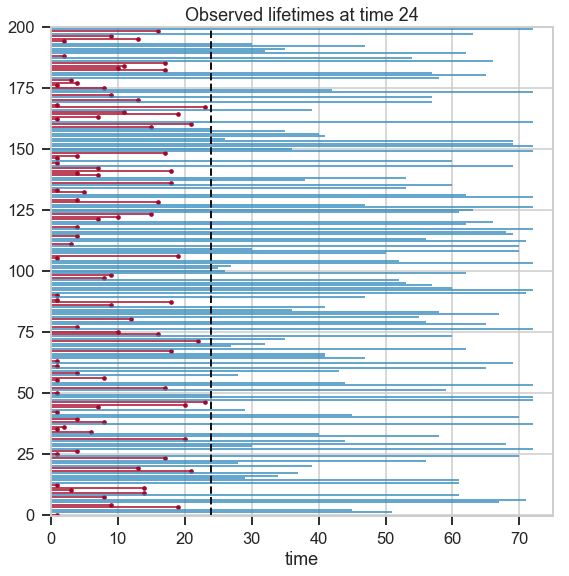

In [162]:
CURRENT_TIME = 24  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 26')

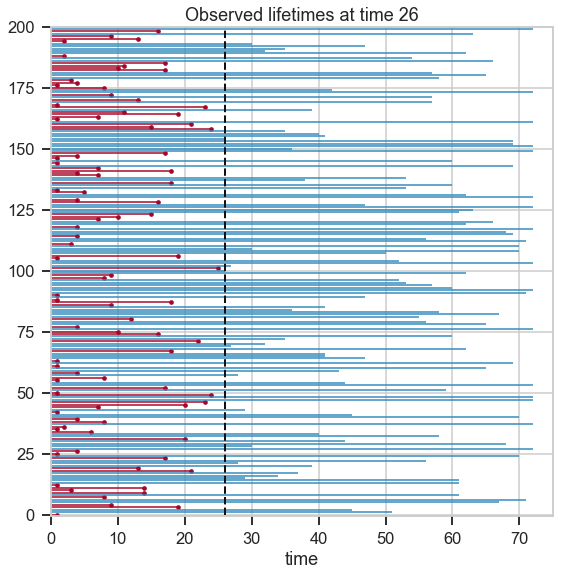

In [163]:
CURRENT_TIME = 26  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 26')

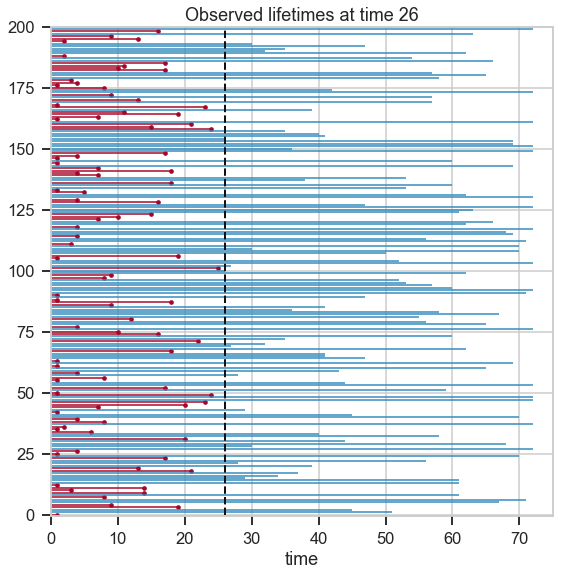

In [164]:
CURRENT_TIME = 26  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 38')

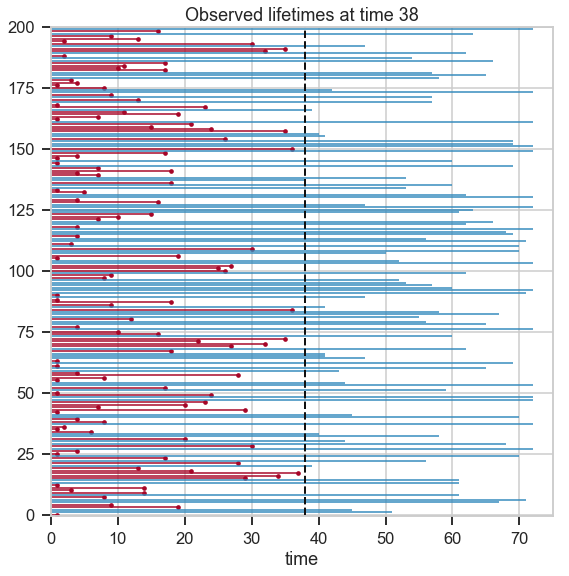

In [165]:
CURRENT_TIME = 38  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 61')

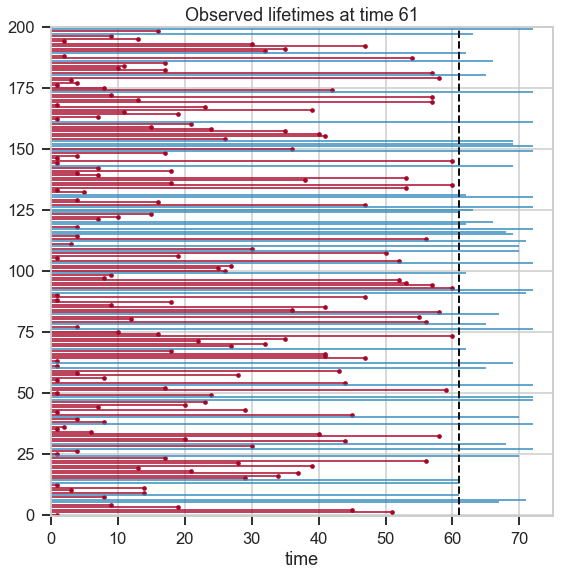

In [166]:
CURRENT_TIME = 61  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 25')

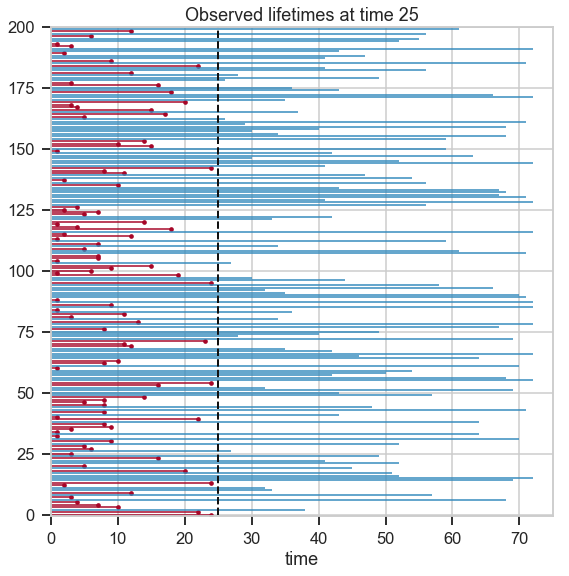

In [167]:
CURRENT_TIME = 25  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 25')

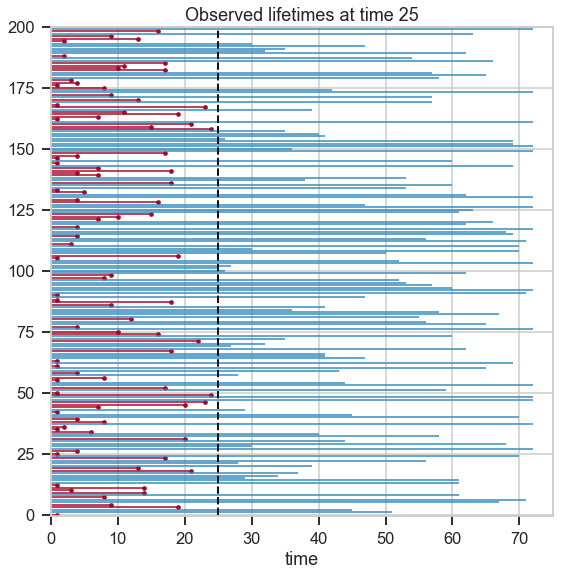

In [168]:
CURRENT_TIME = 25  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 71')

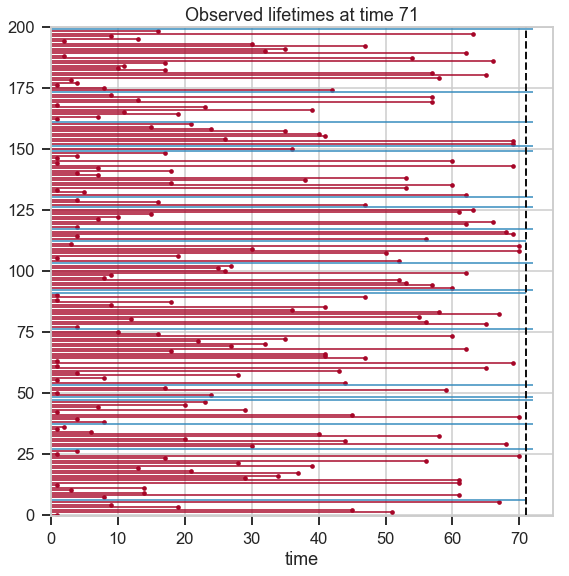

In [169]:
CURRENT_TIME = 71  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N, random_state =1) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 71')

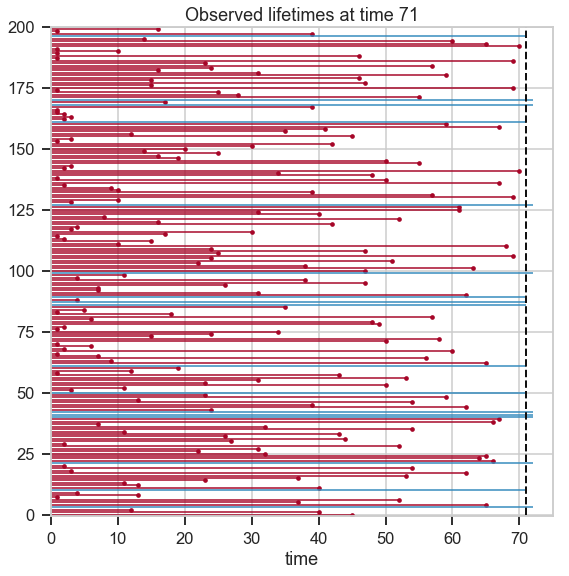

In [170]:
CURRENT_TIME = 71  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 25')

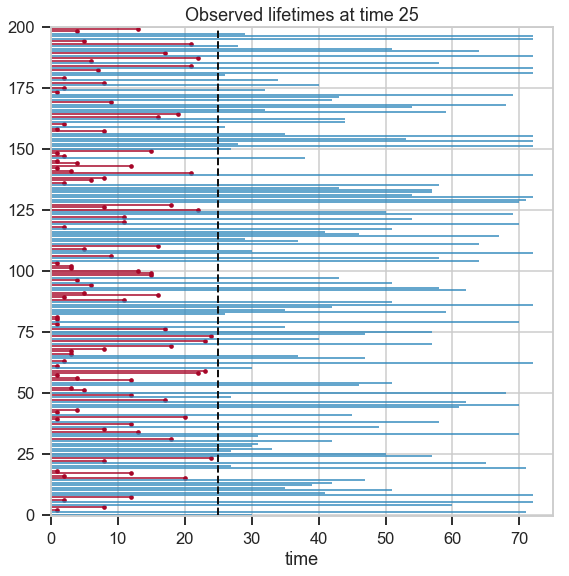

In [171]:
CURRENT_TIME = 25  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 71')

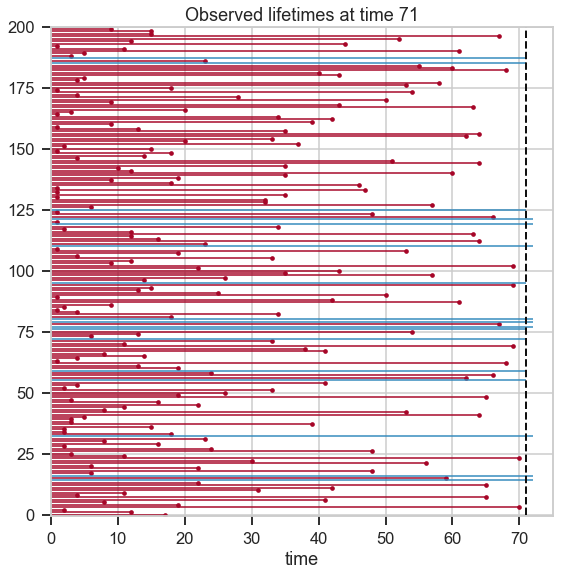

In [172]:
CURRENT_TIME = 71  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Text(0.5,1,'Observed lifetimes at time 71')

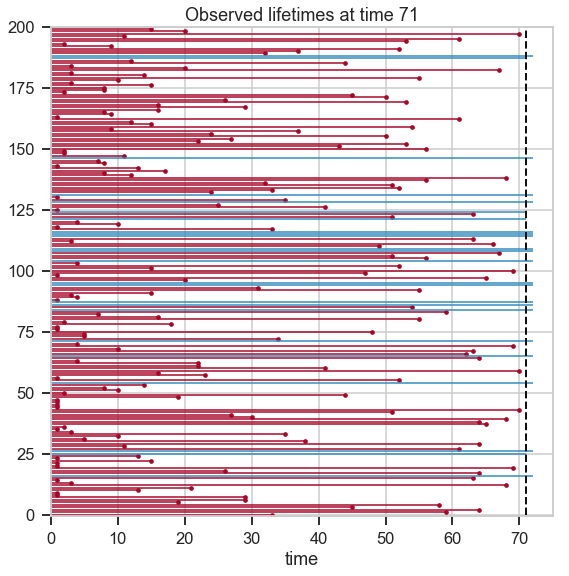

In [173]:
CURRENT_TIME = 71  # customers that have churned before 2 years
N = 200
random_subset = telcom.sample(N) # Select instances randomly from dataset telcom
actual_lifetimes = random_subset['tenure']
actual_lifetimes = actual_lifetimes.reset_index(drop=True)
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME
plt.figure(figsize=(9,9))
bx= plt.subplot()
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed, ax=bx)
ax.vlines(CURRENT_TIME, 0, N, lw=2, linestyles='--')
ax.set_xlim(0, 75)
ax.set_xlabel("time")
ax.set_title("Observed lifetimes at time %d" % (CURRENT_TIME) )

Iteration 1: norm_delta = 2.34743, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.82231, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.94170, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.40984, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence completed after 7 iterations.


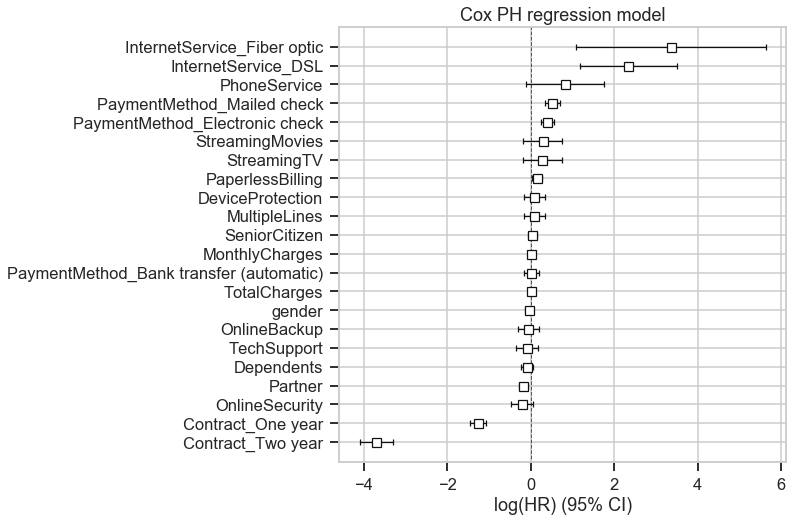

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -12659.69
  time fit was run = 2019-03-06 15:07:40 UTC

---
                                         coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
gender                                  -0.04       0.96      0.05  -0.85   0.40      1.33       -0.13        0.05
SeniorCitizen                            0.03       1.04      0.06   0.61   0.54      0.88       -0.08        0.15
Partner                                 -0.18       0.84      0.06  -3.23 <0.005      9.67       -0.29       -0.07
Dependents                              -0.09       0.91      0.07  -1.31   0.19      2.40       -0.23        0.05
PhoneService                             0.83       2.29      0.47   1.75   0.08      3.63       -0.10        1.76
MultipleLines                            0.09   

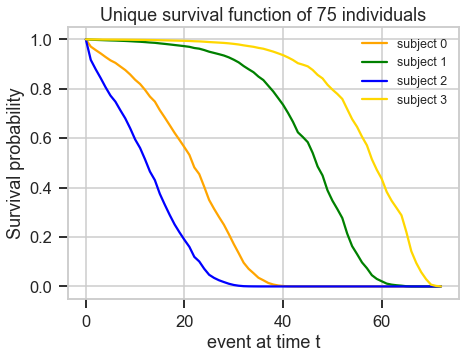

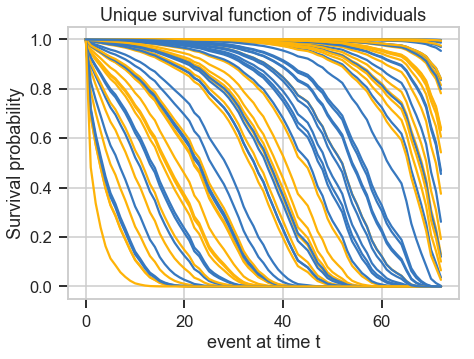

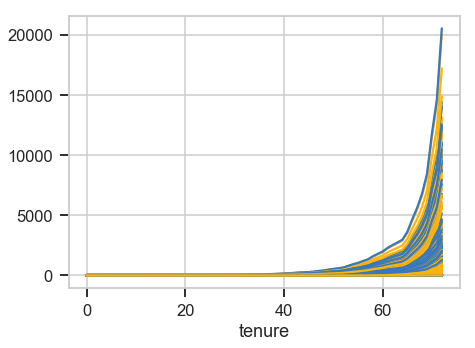

In [174]:
### Using Cox Proportional Hazards model
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
plt.title('Cox PH regression model')
plt.show()

# Stats 
cph.print_summary()
cph.hazards_
cph.baseline_hazard_
cph.score_ # goodness of fit. Here very good! 
# Life expectation of each individual 
cph.predict_expectation(telcom_cox)  # same as telcom_cox_2
cph.predict_median(telcom_cox) # Median 

# Returns the prediction of the survival function for individuals, given covariates.
telcom_cox_2 = telcom_cox.drop(['Churn', 'tenure'], axis=1)

# Get the unique survival functions of four subjects
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.predict_survival_function(telcom_cox_2.iloc[0:4]).plot(ax=ax,color = ['orange', 'green', 'blue', 'gold']) 
plt.legend(['subject 0', 'subject 1', 'subject 2', 'subject 3'], loc='upper right', fontsize='x-small')
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Unique survival function of 75 individuals')
plt.show()

# For many subjects 
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.predict_survival_function(telcom_cox_2.iloc[100:175]).plot(ax=ax)
ax.legend().set_visible(False)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Unique survival function of 75 individuals')

# Prediction of survival proba of every consumer at this particular time. 
cph.predict_survival_function(telcom_cox, times=[1, 10, 25, 50])   # same as telcom_cox_2
# telcom_cox is a dataframe so order of columns does not matter

# Partial hazard
cph.predict_partial_hazard(telcom_cox)

# The cumulative hazard of individuals over the timeline
cph.predict_cumulative_hazard(telcom_cox) # dataframe
# Plot a subset of these cumulative hazards curves. Let's say for 500 individuals. 
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.predict_cumulative_hazard(telcom_cox.iloc[0:500]).plot(ax=ax) 
plt.xlabel('tenure')
ax.legend().set_visible(False)


In [175]:
telcom_cox = telcom.drop(['Contract_Month-to-month', 'PaymentMethod_Credit card (automatic)', 'InternetService_DSL'], axis=1)

Iteration 1: norm_delta = 2.29112, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.51747, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.93542, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.40912, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence completed after 7 iterations.


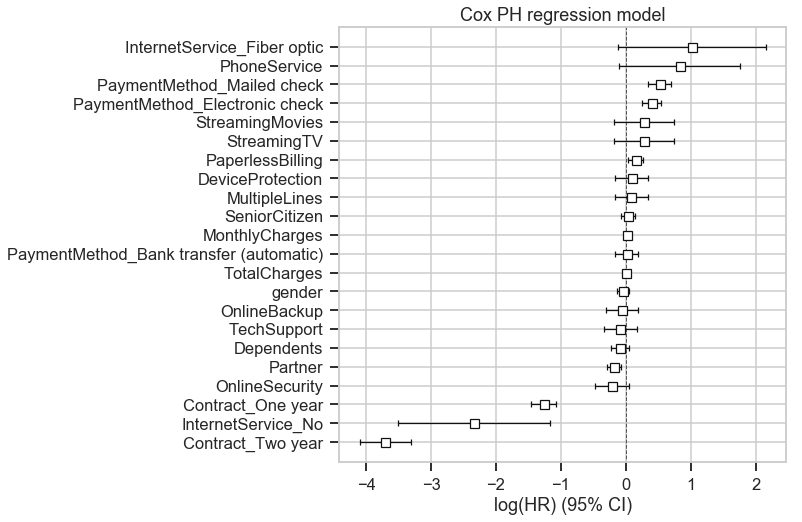

In [176]:
### Using Cox Proportional Hazards model
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
plt.title('Cox PH regression model')
plt.show()


In [177]:
# Stats 
cph.print_summary()
cph.hazards_
cph.baseline_hazard_
cph.score_ # goodness of fit. Here very good! 
# Life expectation of each individual 
cph.predict_expectation(telcom_cox)  # same as telcom_cox_2
cph.predict_median(telcom_cox) # Median 


<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -12659.69
  time fit was run = 2019-03-06 16:32:07 UTC

---
                                         coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
gender                                  -0.04       0.96      0.05  -0.85   0.40      1.33       -0.13        0.05
SeniorCitizen                            0.03       1.04      0.06   0.61   0.54      0.88       -0.08        0.15
Partner                                 -0.18       0.84      0.06  -3.23 <0.005      9.67       -0.29       -0.07
Dependents                              -0.09       0.91      0.07  -1.31   0.19      2.40       -0.23        0.05
PhoneService                             0.83       2.29      0.47   1.75   0.08      3.63       -0.10        1.76
MultipleLines                            0.09   

0.5
0     22.000000
1     47.000000
2     13.000000
3     59.000000
4      4.000000
5      3.000000
6     26.000000
7     26.000000
8     33.000000
9     70.000000
10    22.000000
11    69.000000
12          inf
13    60.000000
14    30.000000
15          inf
16    57.000000
17          inf
18    24.000000
19    20.000000
20    16.000000
21    53.000000
22    35.000000
23          inf
24    58.000000
25    36.000000
26    57.000000
27    25.000000
28          inf
29    18.000000
...         ...
7002  47.000000
7003  44.000000
7004  39.000000
7005  13.000000
7006        inf
7007   4.000000
7008  70.000000
7009  39.000000
7010  29.000000
7011        inf
7012  72.000000
7013  52.000000
7014  19.000000
7015  20.000000
7016  17.000000
7017        inf
7018  16.000000
7019  33.000000
7020  69.000000
7021   3.000000
7022  39.000000
7023        inf
7024  20.000000
7025  34.000000
7026        inf
7027  42.000000
7028        inf
7029  29.000000
7030   4.000000
7031        inf

[7032 rows x 1 columns]

In [178]:
cph.score_

0.9285636735265471

In [179]:
telcom_cox = telcom.drop(['Contract_Month-to-month', 'PaymentMethod_Credit card (automatic)', 'InternetService_DSL'], axis=1)

Iteration 1: norm_delta = 2.29112, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.51747, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.93542, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.40912, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence completed after 7 iterations.


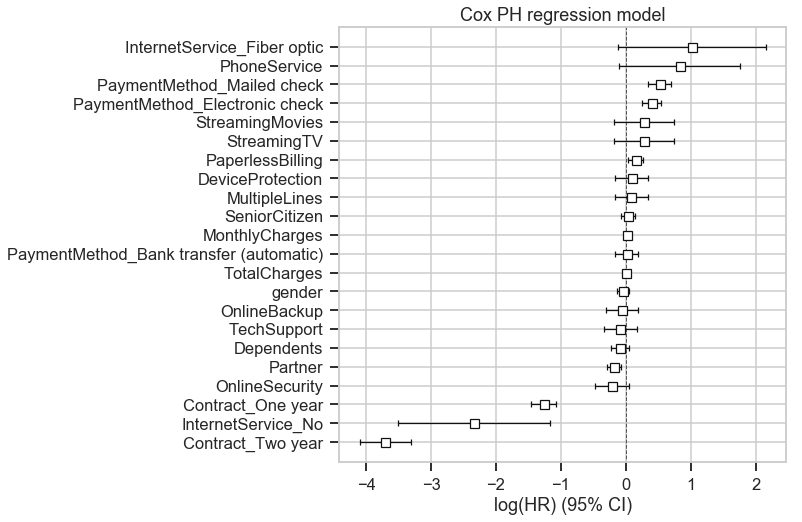

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -12659.69
  time fit was run = 2019-03-06 17:34:09 UTC

---
                                         coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
gender                                  -0.04       0.96      0.05  -0.85   0.40      1.33       -0.13        0.05
SeniorCitizen                            0.03       1.04      0.06   0.61   0.54      0.88       -0.08        0.15
Partner                                 -0.18       0.84      0.06  -3.23 <0.005      9.67       -0.29       -0.07
Dependents                              -0.09       0.91      0.07  -1.31   0.19      2.40       -0.23        0.05
PhoneService                             0.83       2.29      0.47   1.75   0.08      3.63       -0.10        1.76
MultipleLines                            0.09   

0.5
0     22.000000
1     47.000000
2     13.000000
3     59.000000
4      4.000000
5      3.000000
6     26.000000
7     26.000000
8     33.000000
9     70.000000
10    22.000000
11    69.000000
12          inf
13    60.000000
14    30.000000
15          inf
16    57.000000
17          inf
18    24.000000
19    20.000000
20    16.000000
21    53.000000
22    35.000000
23          inf
24    58.000000
25    36.000000
26    57.000000
27    25.000000
28          inf
29    18.000000
...         ...
7002  47.000000
7003  44.000000
7004  39.000000
7005  13.000000
7006        inf
7007   4.000000
7008  70.000000
7009  39.000000
7010  29.000000
7011        inf
7012  72.000000
7013  52.000000
7014  19.000000
7015  20.000000
7016  17.000000
7017        inf
7018  16.000000
7019  33.000000
7020  69.000000
7021   3.000000
7022  39.000000
7023        inf
7024  20.000000
7025  34.000000
7026        inf
7027  42.000000
7028        inf
7029  29.000000
7030   4.000000
7031        inf

[7032 rows x 1 columns]

In [180]:
### Using Cox Proportional Hazards model
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
plt.title('Cox PH regression model')
plt.show()

# Cox model regression table (coef)
cph.print_summary() 

# Stats 
cph.hazards_
cph.baseline_hazard_  # true coefficients 
cph.score_ # goodness of fit. Here very good! 
# Life expectation of each individual 
cph.predict_expectation(telcom_cox)  # same as telcom_cox_2
cph.predict_median(telcom_cox) # Median 


In [181]:
cph.score_

0.9285636735265471

KeyError: "Index([u'InternetService_No'], dtype='object') not in index"

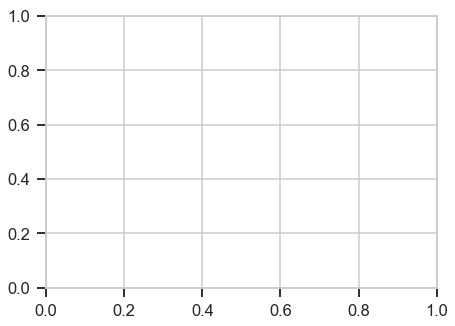

In [182]:
# Get the unique survival functions of four subjects
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.predict_survival_function(telcom_cox_2.iloc[0:4]).plot(ax=ax,color = ['orange', 'green', 'blue', 'gold']) 
plt.legend(['subject 0', 'subject 1', 'subject 2', 'subject 3'], loc='upper right', fontsize='x-small')
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Unique survival function of 75 individuals')
plt.show()

# For many subjects 
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.predict_survival_function(telcom_cox_2.iloc[100:175]).plot(ax=ax)
ax.legend().set_visible(False)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Unique survival function of 75 individuals')


In [183]:
telcom_cox_2 = telcom_cox.drop(['Churn', 'tenure'], axis=1)

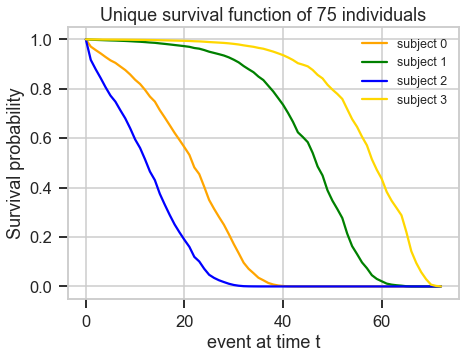

Text(0.5,1,'Unique survival function of 75 individuals')

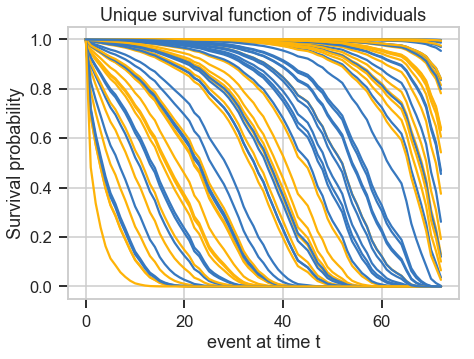

In [184]:
# Get the unique survival functions of four subjects
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.predict_survival_function(telcom_cox_2.iloc[0:4]).plot(ax=ax,color = ['orange', 'green', 'blue', 'gold']) 
plt.legend(['subject 0', 'subject 1', 'subject 2', 'subject 3'], loc='upper right', fontsize='x-small')
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Unique survival function of 75 individuals')
plt.show()

# For many subjects 
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.predict_survival_function(telcom_cox_2.iloc[100:175]).plot(ax=ax)
ax.legend().set_visible(False)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Unique survival function of 75 individuals')



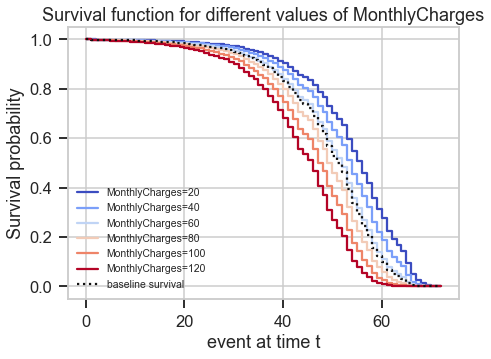

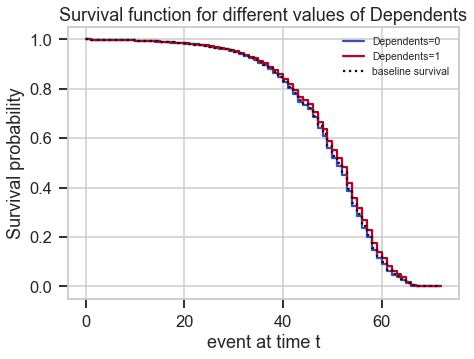

In [185]:
# Look at one covariate in particular ! 
# Plot what the survival curves look like as we vary a single covariate while holding every- thing else equal. 
# This is useful to understand the impact of a covariate, given the model
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('MonthlyCharges', [20, 40, 60, 80, 100, 120], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of MonthlyCharges')
plt.legend(fontsize='xx-small')

# Another, dummy variable this time
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('Dependents', [0,1], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of Dependents')
plt.legend(fontsize='xx-small')


In [186]:
kmf.plot_covariate_groups('MonthlyCharges', [20, 40, 60, 80, 100, 120], cmap='coolwarm', ax=ax)

AttributeError: 'KaplanMeierFitter' object has no attribute 'plot_covariate_groups'

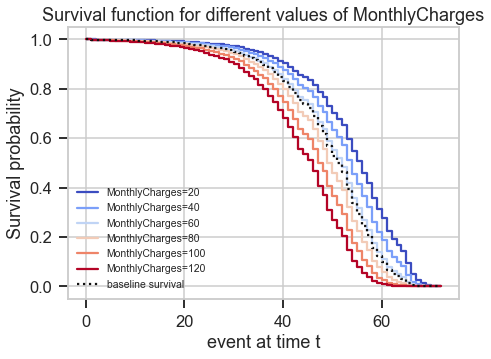

In [187]:
# Look at one covariate in particular ! 
# Plot what the survival curves look like as we vary a single covariate while holding every- thing else equal. 
# This is useful to understand the impact of a covariate, given the model
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('MonthlyCharges', [20, 40, 60, 80, 100, 120], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of MonthlyCharges')
plt.legend(fontsize='xx-small')



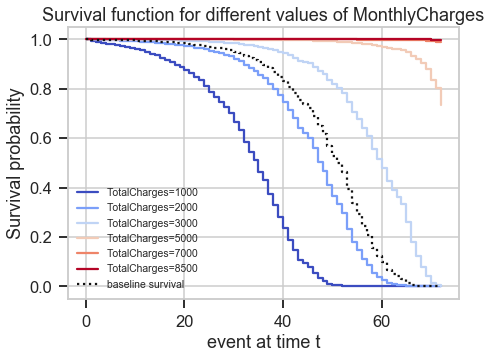

In [188]:
# Look at one covariate in particular ! 
# Plot what the survival curves look like as we vary a single covariate while holding every- thing else equal. 
# This is useful to understand the impact of a covariate, given the model
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('TotalCharges', [1000, 2000, 3000, 5000, 7000, 8500], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of MonthlyCharges')
plt.legend(fontsize='xx-small')




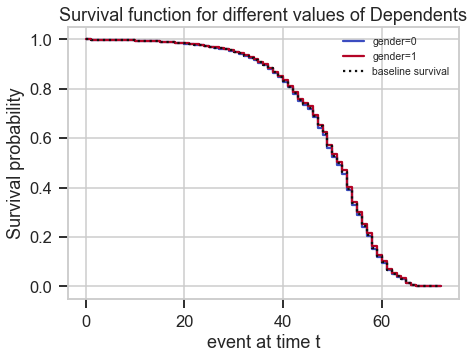

In [189]:
# Another, dummy variable this time
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('gender', [0,1], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of Dependents')
plt.legend(fontsize='xx-small')

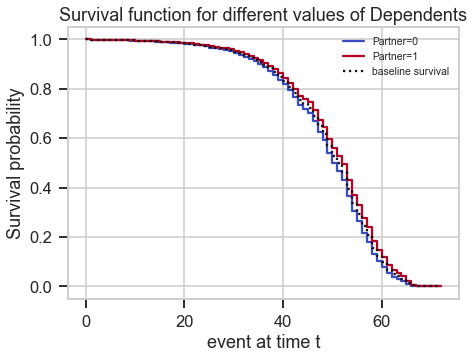

In [190]:
# Another, dummy variable this time
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('Partner', [0,1], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of Dependents')
plt.legend(fontsize='xx-small')

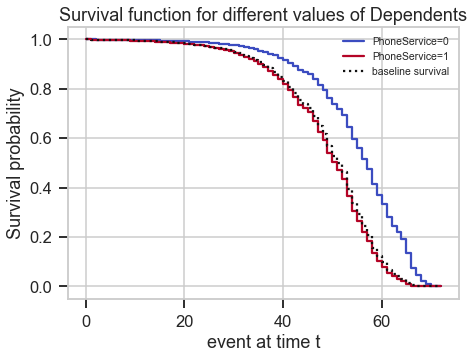

In [191]:
# Another, dummy variable this time
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('PhoneService', [0,1], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of Dependents')
plt.legend(fontsize='xx-small')

KeyError: 'covariate `Contract_Month-to-month` is not present in the original dataset'

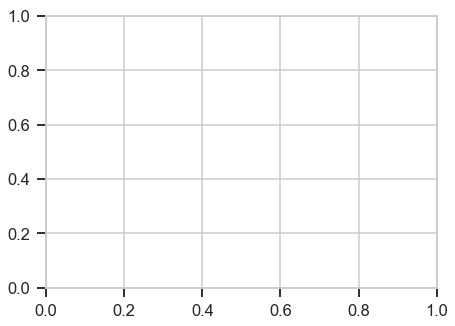

In [192]:
# Another, dummy variable this time
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('Contract_Month-to-month', [0,1], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of Dependents')
plt.legend(fontsize='xx-small')

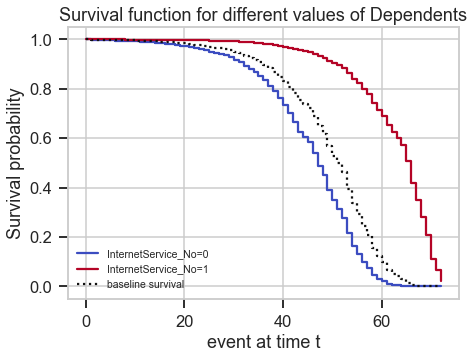

In [193]:
# Another, dummy variable this time
plt.figure(figsize=(7,5))
ax = plt.subplot()
cph.plot_covariate_groups('InternetService_No', [0,1], cmap='coolwarm', ax=ax)
plt.ylabel('Survival probability')
plt.xlabel('event at time t')
plt.title('Survival function for different values of Dependents')
plt.legend(fontsize='xx-small')

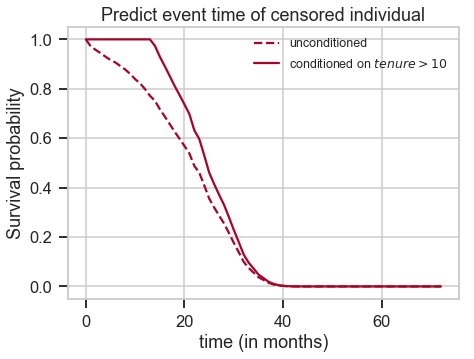

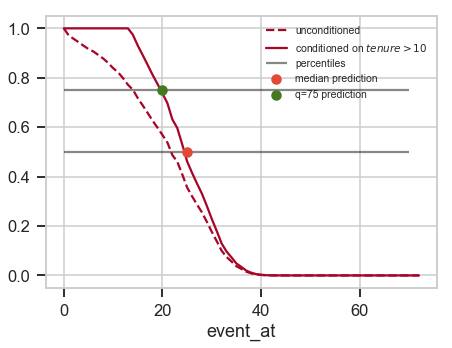

In [194]:
# Predict event time of censored individuals (only those who did not churn during the study time)
censored_subjects = telcom_cox.loc[telcom_cox['Churn'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[telcom_cox.loc[c.name, 'tenure']]).clip_upper(1))
# let's focus on a single subject
subject = 30
plt.figure(figsize=(7,5))
ax = plt.subplot()
unconditioned_sf.iloc[:,subject].plot(ls="--", color="#A60628", label="unconditioned", ax=ax)
conditioned_sf.iloc[:,subject].plot(color="#A60628", label="conditioned on $tenure>10$")
plt.ylabel('Survival probability')
plt.xlabel('time (in months)')
plt.title('Predict event time of censored individual')
plt.legend(fontsize='x-small', loc = 'upper right')


# From here, you can pick a median or percentile as a best guess as to the subject’s event time:
from lifelines.utils import median_survival_times, qth_survival_times
predictions_50 = median_survival_times(conditioned_sf)
predictions_75 = qth_survival_times(0.75, conditioned_sf)

# plotting subject 30 again
subject = 30
plt.figure(figsize=(7,5))
ax = plt.subplot()
unconditioned_sf.iloc[:,subject].plot(ls="--", color="#A60628", label="unconditioned", ax=ax)
conditioned_sf.iloc[:,subject].plot(color="#A60628", label="conditioned on $tenure>10$",ax=ax)
plt.hlines([0.5, 0.75], 0, 70, alpha=0.5, label="percentiles")
plt.scatter(median_survival_times(conditioned_sf.iloc[:,subject]), 0.5,  color="#E24A33", label="median prediction", zorder=20)
plt.scatter(qth_survival_times(0.75, conditioned_sf.iloc[:,subject]), 0.75,  color="#467821", label="q=75 prediction", zorder=20)
plt.legend(fontsize='xx-small', loc = 'upper right')


In [195]:
cph.check_assumptions(telcom_cox)
# Not satisfied for several variables 

# Alternative method
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cph, telcom_cox, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")



The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there are many covariates.

Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and eyeball tests to
determine the most serious violations.


<lifelines.StatisticalResult>
degrees_of_freedom = 1
 null_distribution = chi squared
         test_name = proportional_hazard_test

---
                                              test_statistic      p  -log2(p)
Contract_One year                       km            115.75 <0.005     87.26
                                        rank          103.31 <0.005     78.21
Contract_Two year                       km            152.13 <0.005    113.70
                                        rank          124.61 <0.005     93.70
Depende

In [197]:
### Using Cox Proportional Hazards model
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
plt.title('Cox PH regression model')
plt.show()

# Cox model regression table (coef)
cph.print_summary() 


In [198]:
print(1)

In [199]:
# Check assumption again with new model. 
cph.fit(telcom_cox_strata_TC, duration_col='tenure', event_col='Churn', show_progress = True, strata=[ 'Contract_One year','Contract_Two year','TC_strata', 'TechSupport'] )
cph.check_assumptions(telcom_cox_strata_TC)
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
cph.print_summary(3)


In [200]:
print(1)

In [201]:
print(1)

1


Iteration 1: norm_delta = 2.29112, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.51747, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.93542, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.40912, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence completed after 7 iterations.


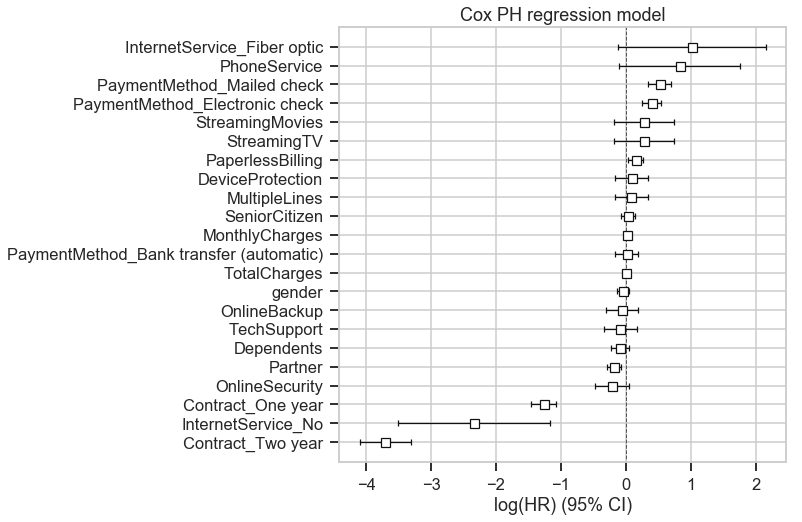

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -12659.69
  time fit was run = 2019-03-08 08:50:43 UTC

---
                                         coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
gender                                  -0.04       0.96      0.05  -0.85   0.40      1.33       -0.13        0.05
SeniorCitizen                            0.03       1.04      0.06   0.61   0.54      0.88       -0.08        0.15
Partner                                 -0.18       0.84      0.06  -3.23 <0.005      9.67       -0.29       -0.07
Dependents                              -0.09       0.91      0.07  -1.31   0.19      2.40       -0.23        0.05
PhoneService                             0.83       2.29      0.47   1.75   0.08      3.63       -0.10        1.76
MultipleLines                            0.09   

In [202]:
### Using Cox Proportional Hazards model
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
plt.title('Cox PH regression model')
plt.show()

# Cox model regression table (coef)
cph.print_summary() 



In [203]:
# Check assumption again with new model. 
cph.fit(telcom_cox_strata_TC, duration_col='tenure', event_col='Churn', show_progress = True, strata=[ 'Contract_One year','Contract_Two year','TC_strata', 'TechSupport'] )
cph.check_assumptions(telcom_cox_strata_TC)
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
cph.print_summary(3)

NameError: name 'telcom_cox_strata_TC' is not defined

Iteration 1: norm_delta = 1.35573, step_size = 0.9500, ll = -11231.42458, newton_decrement = 1171.13798, seconds_since_start = 1.5
Iteration 2: norm_delta = 0.77095, step_size = 0.9500, ll = -10161.59984, newton_decrement = 69.47737, seconds_since_start = 2.8
Iteration 3: norm_delta = 0.07563, step_size = 0.9500, ll = -10090.12736, newton_decrement = 1.91686, seconds_since_start = 4.0
Iteration 4: norm_delta = 0.00709, step_size = 1.0000, ll = -10088.16451, newton_decrement = 0.01773, seconds_since_start = 5.3
Iteration 5: norm_delta = 0.00004, step_size = 1.0000, ll = -10088.14673, newton_decrement = 0.00000, seconds_since_start = 6.5
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -10088.14673, newton_decrement = 0.00000, seconds_since_start = 7.7
Convergence completed after 6 iterations.

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there ar

Concordance = 0.718
Log-likelihood ratio test = 13339.200 on 18 df, -log2(p)=inf


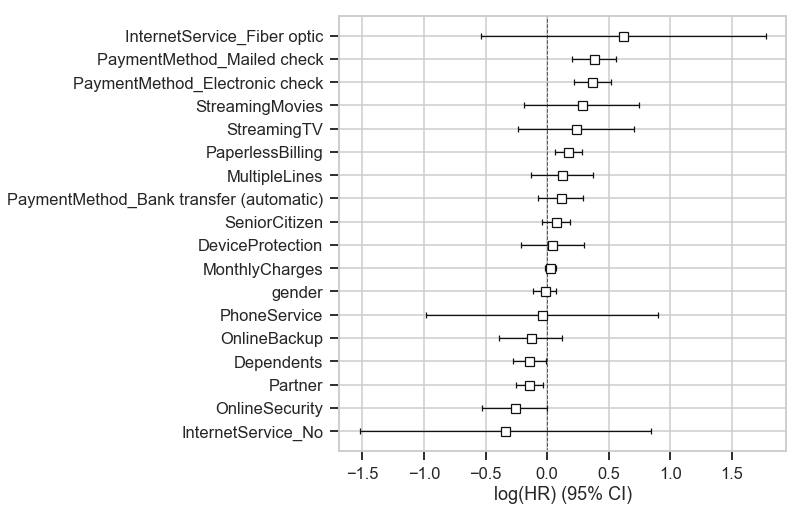

In [204]:
telcom_cox_strata_TC = telcom_cox.copy()
telcom_cox_strata_TC['TC_strata'] = pd.cut(telcom_cox_strata_TC['TotalCharges'], np.arange(0, 9001, 500))
telcom_cox_strata_TC[['TotalCharges', 'TC_strata']].head(100)

# drop the orignal, redundant, TotalCharges column
telcom_cox_strata_TC = telcom_cox_strata_TC.drop('TotalCharges', axis=1)

# Check assumption again with new model. 
cph.fit(telcom_cox_strata_TC, duration_col='tenure', event_col='Churn', show_progress = True, strata=[ 'Contract_Two year','TC_strata'] )
cph.check_assumptions(telcom_cox_strata_TC)
# Still Contract_One year and TechSupport violating assumpations. 

# Check assumption again with new model. 
cph.fit(telcom_cox_strata_TC, duration_col='tenure', event_col='Churn', show_progress = True, strata=[ 'Contract_One year','Contract_Two year','TC_strata', 'TechSupport'] )
cph.check_assumptions(telcom_cox_strata_TC)
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
cph.print_summary(3)

Iteration 1: norm_delta = 2.29112, step_size = 0.9500, ll = -15653.03964, newton_decrement = 2319.28370, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.51747, step_size = 0.9500, ll = -13337.92167, newton_decrement = 468.88276, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.93542, step_size = 0.9500, ll = -12806.44214, newton_decrement = 115.81352, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.40912, step_size = 1.0000, ll = -12674.58736, newton_decrement = 13.68172, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.05542, step_size = 1.0000, ll = -12659.91989, newton_decrement = 0.22330, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00139, step_size = 1.0000, ll = -12659.69305, newton_decrement = 0.00015, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -12659.69290, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence completed after 7 iterations.


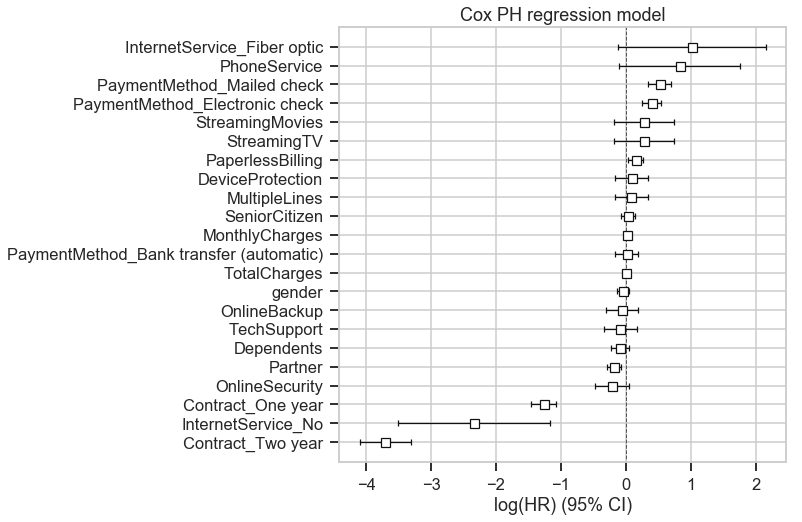

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -12659.69
  time fit was run = 2019-03-08 08:52:18 UTC

---
                                         coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
gender                                  -0.04       0.96      0.05  -0.85   0.40      1.33       -0.13        0.05
SeniorCitizen                            0.03       1.04      0.06   0.61   0.54      0.88       -0.08        0.15
Partner                                 -0.18       0.84      0.06  -3.23 <0.005      9.67       -0.29       -0.07
Dependents                              -0.09       0.91      0.07  -1.31   0.19      2.40       -0.23        0.05
PhoneService                             0.83       2.29      0.47   1.75   0.08      3.63       -0.10        1.76
MultipleLines                            0.09   

In [205]:
cph = CoxPHFitter()
cph.fit(telcom_cox, duration_col='tenure', event_col='Churn', show_progress = True )
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)
plt.title('Cox PH regression model')
plt.show()

# Cox model regression table (coef)
cph.print_summary() 



In [206]:
cph.print_summary(3) 

<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -12659.693
  time fit was run = 2019-03-08 08:52:18 UTC

---
                                          coef  exp(coef)  se(coef)       z       p  -log2(p)  lower 0.95  upper 0.95
gender                                  -0.039      0.961     0.047  -0.846   0.398     1.331      -0.131       0.052
SeniorCitizen                            0.034      1.035     0.057   0.609   0.543     0.882      -0.076       0.145
Partner                                 -0.178      0.837     0.055  -3.233   0.001     9.673      -0.286      -0.070
Dependents                              -0.092      0.913     0.070  -1.311   0.190     2.397      -0.228       0.045
PhoneService                             0.828      2.289     0.474   1.746   0.081     3.631      -0.101       1.758
MultipleLines                

Iteration 1: norm_delta = 1.58681, step_size = 0.9500, ll = -9735.09230, newton_decrement = 789.78838, seconds_since_start = 5.3
Iteration 2: norm_delta = 0.87127, step_size = 0.9500, ll = -9007.65473, newton_decrement = 23.71350, seconds_since_start = 10.3
Iteration 3: norm_delta = 0.06324, step_size = 0.9500, ll = -8983.67208, newton_decrement = 0.22933, seconds_since_start = 17.1
Iteration 4: norm_delta = 0.00386, step_size = 1.0000, ll = -8983.44060, newton_decrement = 0.00114, seconds_since_start = 24.8
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -8983.43946, newton_decrement = 0.00000, seconds_since_start = 32.1
Convergence completed after 5 iterations.
Proportional hazard assumption looks okay.


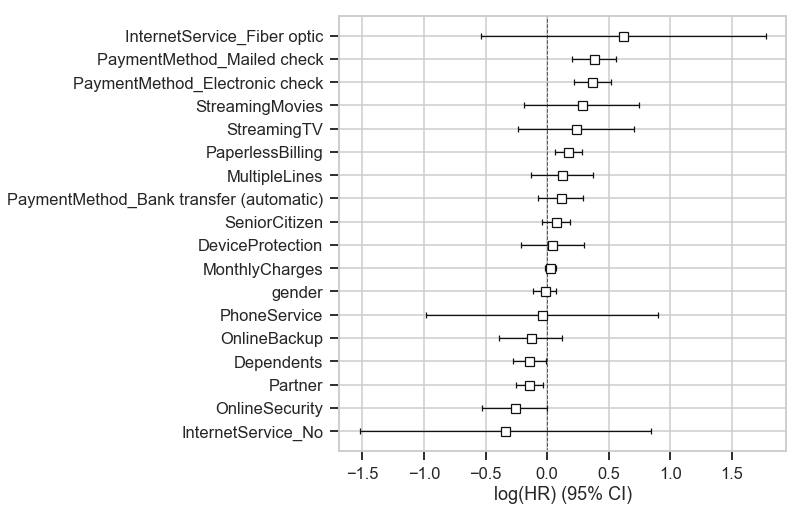

In [207]:
cph.fit(telcom_cox_strata_TC, duration_col='tenure', event_col='Churn', show_progress = True, strata=[ 'Contract_One year','Contract_Two year','TC_strata', 'TechSupport'] )
cph.check_assumptions(telcom_cox_strata_TC)
plt.figure(figsize=(8,8))
ax = plt.subplot()
cph.plot(ax=ax)

In [ ]:
# Survival curves for some groups - Here Dependents 
has_dependents = (telcom.InternetService_Fiber optic == 1)
kmf.fit(T[~has_dependents], C[~has_dependents], label='no PhoneService')
ax = kmf.plot(figsize=(12,6))
kmf.fit(T[has_dependents], C[has_dependents], label='PhoneService')
ax = kmf.plot(ax=ax)
plt.title("Survival Curve of Telco's Customers")
plt.xlabel("Timeline (in months)")
plt.ylabel("Probability of survival")
# See improved graph version below

In [ ]:
print(1)